# Exp7: Sentence Embeddings
This file tests neural networks trained on sentence embeddings to predict the presence of grammatical constructions in them.

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from transformers import BertModel, BertTokenizer#, BertForSequenceClassification
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score
import random
from tqdm import tqdm
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
import config

torch.manual_seed(config.SEED)
np.random.seed(config.SEED)
random.seed(config.SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/scratch_local/mpb672-5187287/tmp/ipykernel_37349/2889753141.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/mnt/qb/work/meurers/mpb672/conda_envs/llm2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#torch.cuda.empty_cache()
#print(torch.cuda.memory_summary(device=device))

Load dataset

In [2]:
df = pd.read_json('../dat/egpaugmented_54x100.json')

Load and test embeddings model

In [3]:
# Extracting one construct with its examples
row = df.iloc[10]
print(row['Can-do statement'])
print(row['Example'])
print("\n")
for element in row['augmented_examples'][:10]:
    print(element)
print("\n")
for element in row['augmented_negative_examples'][:10]:
    print(element)

class SentenceDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        #return torch.tensor(self.embeddings[idx], device=device), torch.tensor(self.labels[idx], device=device)
        encoding = self.tokenizer.encode_plus(
            self.sentences[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
    
def get_dataset(row, tokenizer, max_len, random_negatives=True):
    # assemble dataset for one construction
    # 50% positive examples
    sentences = list(row['augmented_examples'])
    labels = [1] * len(row['augmented_examples'])

    if random_negatives:
        ratio = 0.5
        num_rands = int(len(sentences) * ratio)
        num_augs = int(len(sentences) * (1-ratio))

        # 25% random negative examples (positive from other constructions)
        neg_examples = [example for sublist in df.loc[df['#'] != row['#'], 'augmented_examples'].to_list() for example in sublist]
        random.shuffle(neg_examples)
        sentences += neg_examples[:num_rands]
        labels += [0] * len(neg_examples[:num_rands])

        # 25% augmented negative examples
        aug_neg_examples = row['augmented_negative_examples']
        random.shuffle(aug_neg_examples)
        sentences += aug_neg_examples[:num_augs]
        labels += [0] * len(aug_neg_examples[:num_augs])
    else:
        sentences += row['augmented_negative_examples']
        labels = [0] * len(row['augmented_negative_examples'])

    #embeddings = embeddings_model.encode(sentences)
    return SentenceDataset(sentences, labels, tokenizer, max_len)

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir="/mnt/qb/work/meurers/mpb672/cache")
max_len = 128  # Max length for BERT

# Get dataset for a specific row
dataset = get_dataset(row, tokenizer, max_len)

Can use the past continuous with a limited range of adverbs in the normal mid position. 
I was just watching a football match. 

[talking about wanting to get a kitten] I was always dreaming about it.


She was constantly complaining about the weather.
They were frequently laughing at their inside jokes.
He was often grumbling about his annoying neighbor.
We were regularly studying together for our exams.
The children were always playing in the backyard.
She was usually chatting on the phone with her best friend during lunch break.
He was occasionally singing in the shower.
They were often arguing about trivial matters.
The students were constantly whispering to each other during the test.
I was sometimes daydreaming in class.


I watched a football match a moment ago.
I always dreamed about getting a kitten.
She complained about the weather regularly.
They laughed at their inside jokes frequently.
He grumbled about his annoying neighbor often.
We studied together regularly for our exa

Let's define our network, a simple two layer Feed Forward Neural Network with a sigmoidal activation function.

In [ ]:
#model = BertForSequenceClassification.from_pretrained('bert-base-uncased', cache_dir="/mnt/qb/work/meurers/mpb672/cache").to(device)
#model

In [6]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

Total Parameters: 109483778
Trainable Parameters: 109483778


In [4]:
model = BertModel.from_pretrained('bert-base-uncased', cache_dir="/mnt/qb/work/meurers/mpb672/cache")
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [6]:
class TaskHead(torch.nn.Module):
    def __init__(self, bert_hidden_size, num_labels, dropout_rate=0.1):
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.classifier = torch.nn.Linear(bert_hidden_size, num_labels)

    def forward(self, x):
        x = self.dropout(x)
        return self.classifier(x)

class MultiTaskBERT(torch.nn.Module):
    def __init__(self, bert, task_heads):
        super().__init__()
        self.bert = bert
        self.task_heads = torch.nn.ModuleList(task_heads)

    def forward(self, input_ids, attention_mask, task_id):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        task_output = self.task_heads[task_id](pooled_output)
        return task_output

In [36]:
num_classifiers = 53
task_heads = [TaskHead(model.config.hidden_size, 2) for _ in range(num_classifiers)]
multi_task_model = MultiTaskBERT(model, task_heads).to(device)

In [37]:
datasets = [get_dataset(df.iloc[idx], tokenizer, max_len) for idx in range(num_classifiers)]

def get_loaders(dataset, batch_size=16):
    total_size = len(dataset)
    train_size = int(0.8 * total_size)
    val_size = total_size - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, val_dataloader

dataloaders = [get_loaders(dataset) for dataset in datasets]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:57<00:00,  1.08s/it]


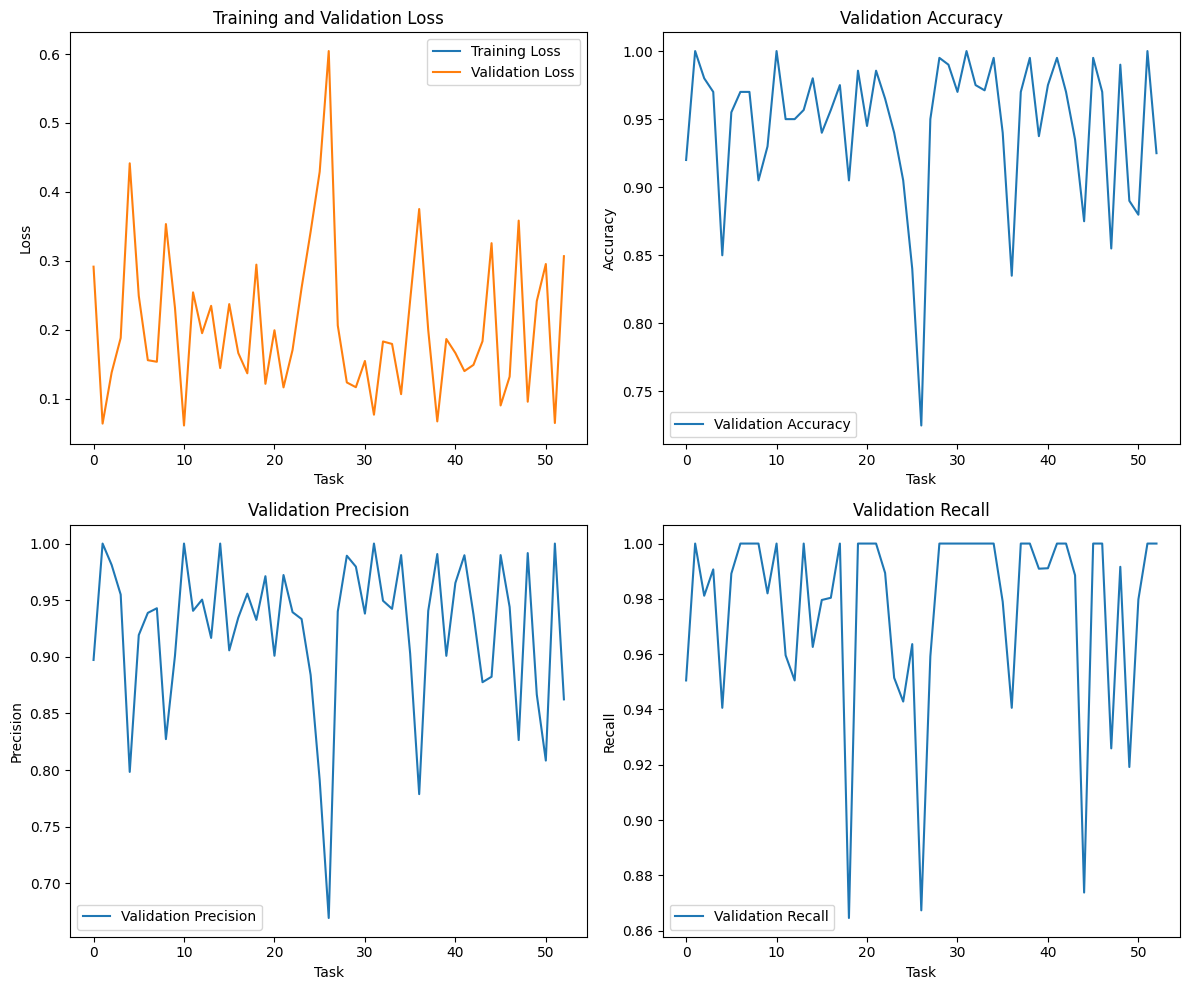

(BertModel(
   (embeddings): BertEmbeddings(
     (word_embeddings): Embedding(30522, 768, padding_idx=0)
     (position_embeddings): Embedding(512, 768)
     (token_type_embeddings): Embedding(2, 768)
     (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     (dropout): Dropout(p=0.1, inplace=False)
   )
   (encoder): BertEncoder(
     (layer): ModuleList(
       (0-11): 12 x BertLayer(
         (attention): BertAttention(
           (self): BertSelfAttention(
             (query): Linear(in_features=768, out_features=768, bias=True)
             (key): Linear(in_features=768, out_features=768, bias=True)
             (value): Linear(in_features=768, out_features=768, bias=True)
             (dropout): Dropout(p=0.1, inplace=False)
           )
           (output): BertSelfOutput(
             (dense): Linear(in_features=768, out_features=768, bias=True)
             (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
             (dropout): Dropout(p=

In [42]:
criterion = torch.nn.CrossEntropyLoss()

def train(model, verbose=True, plots=True, n_epochs_stop = 10, lr=0.0001, num_epochs=1):
    optimizer = torch.optim.AdamW(model.parameters(), lr)
    train_losses = []
    
    for epoch in range(num_epochs):  # Number of epochs
        model.train()  # Set the model to training mode
        total_loss = 0
        train_steps = 0
        
        train_loaders = zip(*[loader[0] for loader in dataloaders])
        num_batches = len(dataloaders[0][0])
        
        for batches in tqdm(train_loaders, total=num_batches):
            for task_id, batch in enumerate(batches):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
    
                outputs = multi_task_model(input_ids, attention_mask=attention_mask, task_id=task_id)
                loss = criterion(outputs, labels)
                loss.backward()
                total_loss += loss.item()
                train_steps += 1

            # Update model parameters after processing all tasks
            optimizer.step()
            optimizer.zero_grad()
        
        avg_train_loss = total_loss / train_steps
        train_losses.append(avg_train_loss)
        
    # Validation phase after all epochs
    model.eval()  # Set the model to evaluation mode
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_dataloaders = [loader[1] for loader in dataloaders]
    for task_id, val_loader in tqdm(enumerate(val_dataloaders), total=len(val_dataloaders)):
        val_loss = 0
        val_steps = 0
        correct = 0
        total = 0
        all_targets = []
        all_predictions = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
    
                outputs = multi_task_model(input_ids, attention_mask=attention_mask, task_id=task_id)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_steps += 1
    
                predicted = outputs.argmax(dim=1)  # Assuming a classification task
    
                # Accumulate all targets and predictions
                all_targets.extend(labels.tolist())
                all_predictions.extend(predicted.tolist())
    
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / val_steps
        val_losses.append(avg_val_loss)
        val_accuracies.append(correct / total)
        val_precisions.append(precision_score(all_targets, all_predictions, average='binary'))
        val_recalls.append(recall_score(all_targets, all_predictions, average='binary'))

    if plots:
        plt.figure(figsize=(12, 10))

        plt.subplot(2, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Task')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.xlabel('Task')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy')
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(val_precisions, label='Validation Precision')
        plt.xlabel('Task')
        plt.ylabel('Precision')
        plt.title('Validation Precision')
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(val_recalls, label='Validation Recall')
        plt.xlabel('Task')
        plt.ylabel('Recall')
        plt.title('Validation Recall')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return model, val_accuracies, val_precisions, val_recalls

train(model, verbose=False)

In [48]:
multi_task_model.save_pretrained("../models/multibert/")

AttributeError: 'MultiTaskBERT' object has no attribute 'save_pretrained'

Now we can train the network with the sentence embeddings.

In [41]:
df.iloc[20:30]

,Unnamed: 0,#,SuperCategory,SubCategory,Level,Lexical Range,guideword,Can-do statement,Example,type,prompt,augmented_examples,augmented_negative_examples
68,68,69,ADJECTIVES,superlatives,B1,2.0,FORM/USE: COMPLEX NOUN PHRASES,Can form an increasing range of complex noun p...,Yesterday was the most exciting day of my life...,FORM/USE,Create 20 more examples for the grammatical co...,[The Grand Canyon is one of the most breathtak...,"[Among the structures in Paris, the Eiffel Tow..."
1112,1112,1113,CLAUSES,conditional,B1,NaN,"FORM/USE: 'IF I WERE YOU' + 'WOULD', FUTURE, I...",Can use 'if I were you' and 'would' in the mai...,"Well, if I were you I would go to a small scho...",FORM/USE,Create 20 more examples for the grammatical co...,"[If I were you, I would buy that house before ...",[It would be advantageous for you to seek guid...
1111,1111,1112,CLAUSES,conditional,B1,NaN,"FORM/USE: 'IF' + PAST SIMPLE + 'WOULD', FUTURE...",Can form conditional subordinate clauses with ...,Maybe it would be more fun if you went with yo...,FORM/USE,Create 20 more examples for the grammatical co...,"[If she won the lottery, she would buy a mansi...",[Where would you like to go on holiday with yo...
949,949,950,PRONOUNS,demonstratives,B1,NaN,"USE: 'THOSE', ALREADY MENTIONED",Can use 'those' as a pronoun to refer to thing...,Those are the things I like the most about her...,USE,Create 20 more examples for the grammatical co...,[I asked her to bring the books from her libra...,[The products I ended up buying were the ones ...
99,99,100,ADVERBS,adverbs as modifiers,B1,2.0,USE: LINKING,Can use an increasing range of adverbs ('there...,You don't like city's with a lot of people. Th...,USE,Create 20 more examples for the grammatical co...,"[You didn't study for the test. Therefore, it'...",[She didn't want to go out alone at night. If ...
911,911,912,PRONOUNS,reflexive,B1,NaN,"USE: SINGULAR, FOR EMPHASIS",Can use the singular reflexive pronouns 'mysel...,The best solution will be if you decide yourse...,USE,Create 20 more examples for the grammatical co...,[I couldn't believe it myself when I won the c...,[You can achieve anything if you believe in yo...
121,121,122,ADVERBS,adverbs and adverb phrases: types and meanings,B2,NaN,"FORM: DEGREE, MODIFYING PRONOUNS",Can use degree adverbs to modify pronouns. ► p...,You can eat very well and pay almost nothing. ...,FORM,Create 20 more examples for the grammatical co...,[He always speaks so confidently about his ach...,"[He knows me completely, thoroughly understand..."
931,931,932,PRONOUNS,subject/ object,B2,NaN,FORM: (OBJECT) USING 'IT' TO INTRODUCE,Can use 'it' as an object with 'make' to intro...,This shyness makes it hard for me to speak in ...,FORM,Create 20 more examples for the grammatical co...,[I find it annoying when people talk loudly on...,[Printing important documents is challenging f...
540,540,541,MODALITY,must,B2,2.0,FORM: WITH ADVERBS,Can use 'must' with an increasing range of adv...,"To sum up, we must all act immediately because...",FORM,Create 20 more examples for the grammatical co...,"[They must all attend the meeting tomorrow., W...",[Achieving success requires a strong belief in...
195,195,196,CLAUSES,imperatives,B2,NaN,"FORM/USE: 'DO NOT', EMPHASIS",Can use 'do not' for emphasis or in formal con...,Do not forget to have a break at lunchtime and...,FORM/USE,Create 20 more examples for the grammatical co...,[Do not underestimate the importance of regula...,[Stand strong and don't give in to peer pressu...


In [52]:
probe = "If I were you I would not dare to sing that loud."
encoding = tokenizer.encode_plus(
    probe,
    add_special_tokens=True,
    max_length=max_len,
    return_token_type_ids=False,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt',
)

input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)
values = [torch.argmax(multi_task_model(input_ids, attention_mask=attention_mask, task_id=id)).item() for id in range(53)]
print(values)
df.iloc[values]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]


,Unnamed: 0,#,SuperCategory,SubCategory,Level,Lexical Range,guideword,Can-do statement,Example,type,prompt,augmented_examples,augmented_negative_examples
646,646,647,NOUNS,noun phrases,A1,1.0,FORM: DETERMINER + NOUN,Can form simple noun phrases with a limited ra...,There is also a park near my house. \n\nMy hus...,FORM,Create 20 more examples for the grammatical co...,"[She needs a pen for her writing., We have a d...","[Can you give me one pen?, We require a table ..."
646,646,647,NOUNS,noun phrases,A1,1.0,FORM: DETERMINER + NOUN,Can form simple noun phrases with a limited ra...,There is also a park near my house. \n\nMy hus...,FORM,Create 20 more examples for the grammatical co...,"[She needs a pen for her writing., We have a d...","[Can you give me one pen?, We require a table ..."
646,646,647,NOUNS,noun phrases,A1,1.0,FORM: DETERMINER + NOUN,Can form simple noun phrases with a limited ra...,There is also a park near my house. \n\nMy hus...,FORM,Create 20 more examples for the grammatical co...,"[She needs a pen for her writing., We have a d...","[Can you give me one pen?, We require a table ..."
646,646,647,NOUNS,noun phrases,A1,1.0,FORM: DETERMINER + NOUN,Can form simple noun phrases with a limited ra...,There is also a park near my house. \n\nMy hus...,FORM,Create 20 more examples for the grammatical co...,"[She needs a pen for her writing., We have a d...","[Can you give me one pen?, We require a table ..."
646,646,647,NOUNS,noun phrases,A1,1.0,FORM: DETERMINER + NOUN,Can form simple noun phrases with a limited ra...,There is also a park near my house. \n\nMy hus...,FORM,Create 20 more examples for the grammatical co...,"[She needs a pen for her writing., We have a d...","[Can you give me one pen?, We require a table ..."
646,646,647,NOUNS,noun phrases,A1,1.0,FORM: DETERMINER + NOUN,Can form simple noun phrases with a limited ra...,There is also a park near my house. \n\nMy hus...,FORM,Create 20 more examples for the grammatical co...,"[She needs a pen for her writing., We have a d...","[Can you give me one pen?, We require a table ..."
646,646,647,NOUNS,noun phrases,A1,1.0,FORM: DETERMINER + NOUN,Can form simple noun phrases with a limited ra...,There is also a park near my house. \n\nMy hus...,FORM,Create 20 more examples for the grammatical co...,"[She needs a pen for her writing., We have a d...","[Can you give me one pen?, We require a table ..."
646,646,647,NOUNS,noun phrases,A1,1.0,FORM: DETERMINER + NOUN,Can form simple noun phrases with a limited ra...,There is also a park near my house. \n\nMy hus...,FORM,Create 20 more examples for the grammatical co...,"[She needs a pen for her writing., We have a d...","[Can you give me one pen?, We require a table ..."
646,646,647,NOUNS,noun phrases,A1,1.0,FORM: DETERMINER + NOUN,Can form simple noun phrases with a limited ra...,There is also a park near my house. \n\nMy hus...,FORM,Create 20 more examples for the grammatical co...,"[She needs a pen for her writing., We have a d...","[Can you give me one pen?, We require a table ..."
646,646,647,NOUNS,noun phrases,A1,1.0,FORM: DETERMINER + NOUN,Can form simple noun phrases with a limited ra...,There is also a park near my house. \n\nMy hus...,FORM,Create 20 more examples for the grammatical co...,"[She needs a pen for her writing., We have a d...","[Can you give me one pen?, We require a table ..."


Let's try cross validation to make sure that the validation is not influenced by the validation set sampling.

Can form simple noun phrases with a limited range of determiners + singular and plural nouns. ► Nouns and noun phrases: functions
FOLD 0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  3.52it/s]


Epoch [1/1], Training Loss: 0.2257, Validation Loss: 0.0016, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


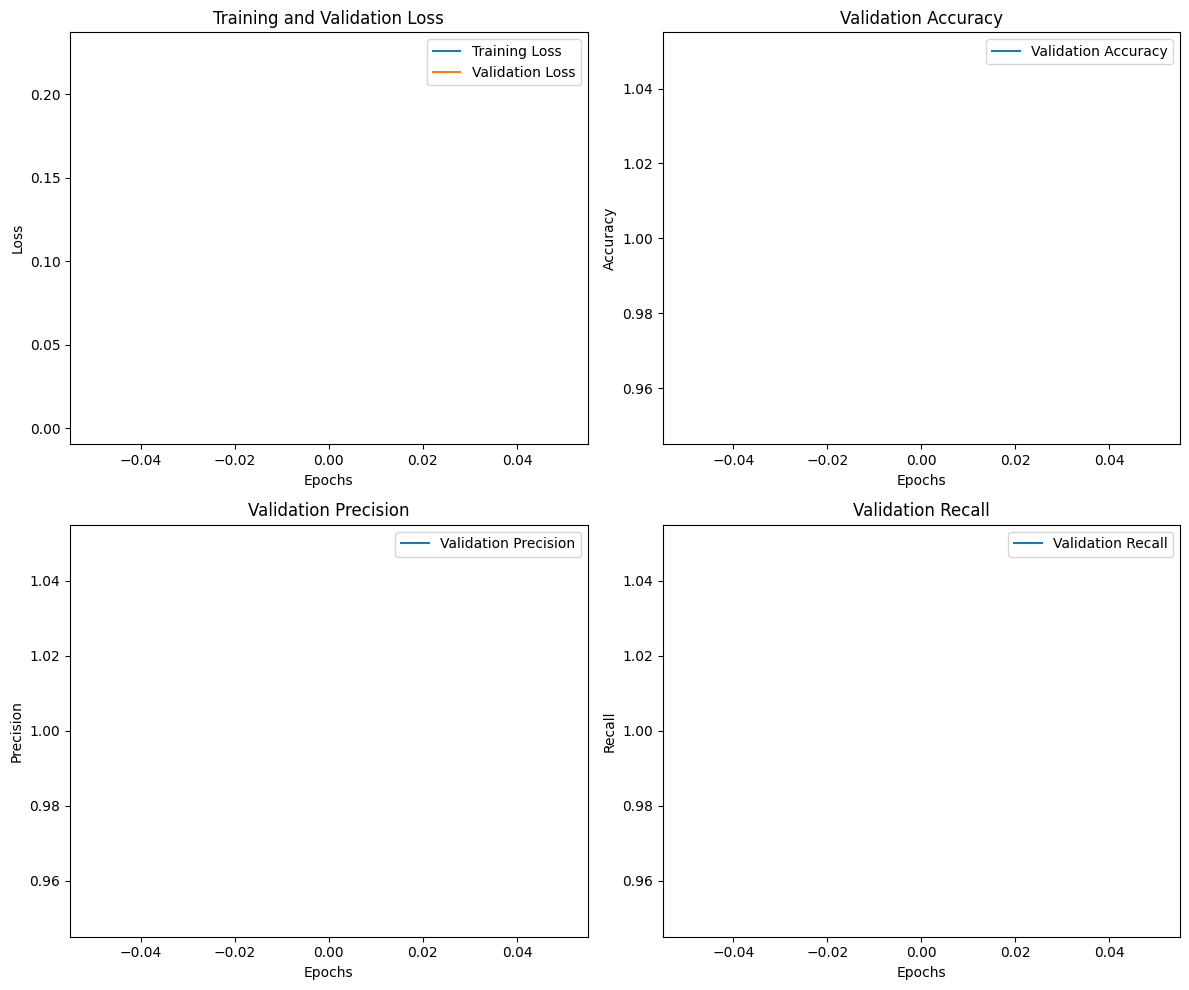

FOLD 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.08it/s]


Epoch [1/1], Training Loss: 0.1749, Validation Loss: 0.0014, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


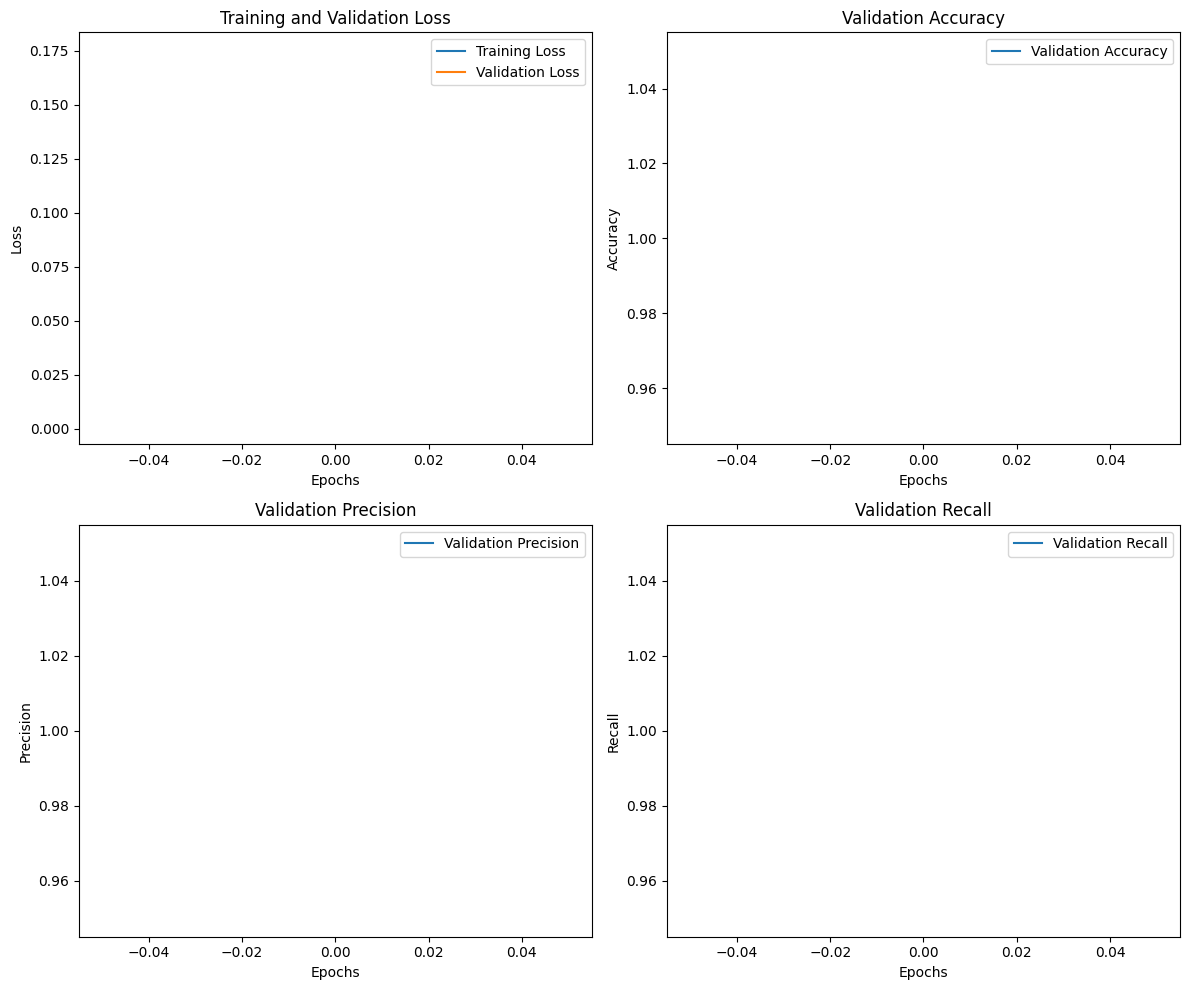

FOLD 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.05it/s]


Epoch [1/1], Training Loss: 0.2679, Validation Loss: 0.0035, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


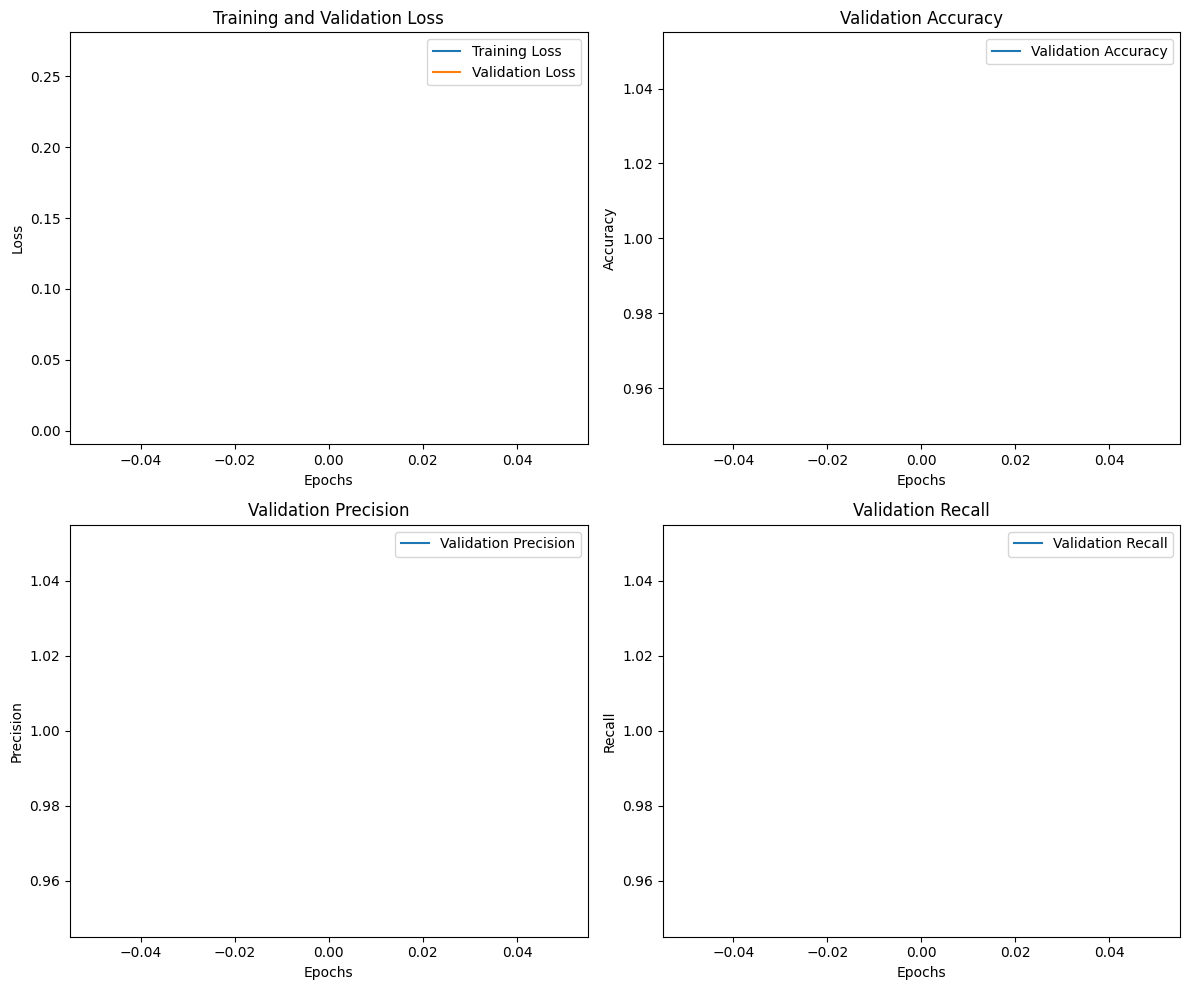

[1.0, 1.0, 1.0]
Can use 'very' to modify common gradable adjectives.
FOLD 0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.06it/s]


Epoch [1/1], Training Loss: 0.1774, Validation Loss: 0.0056, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


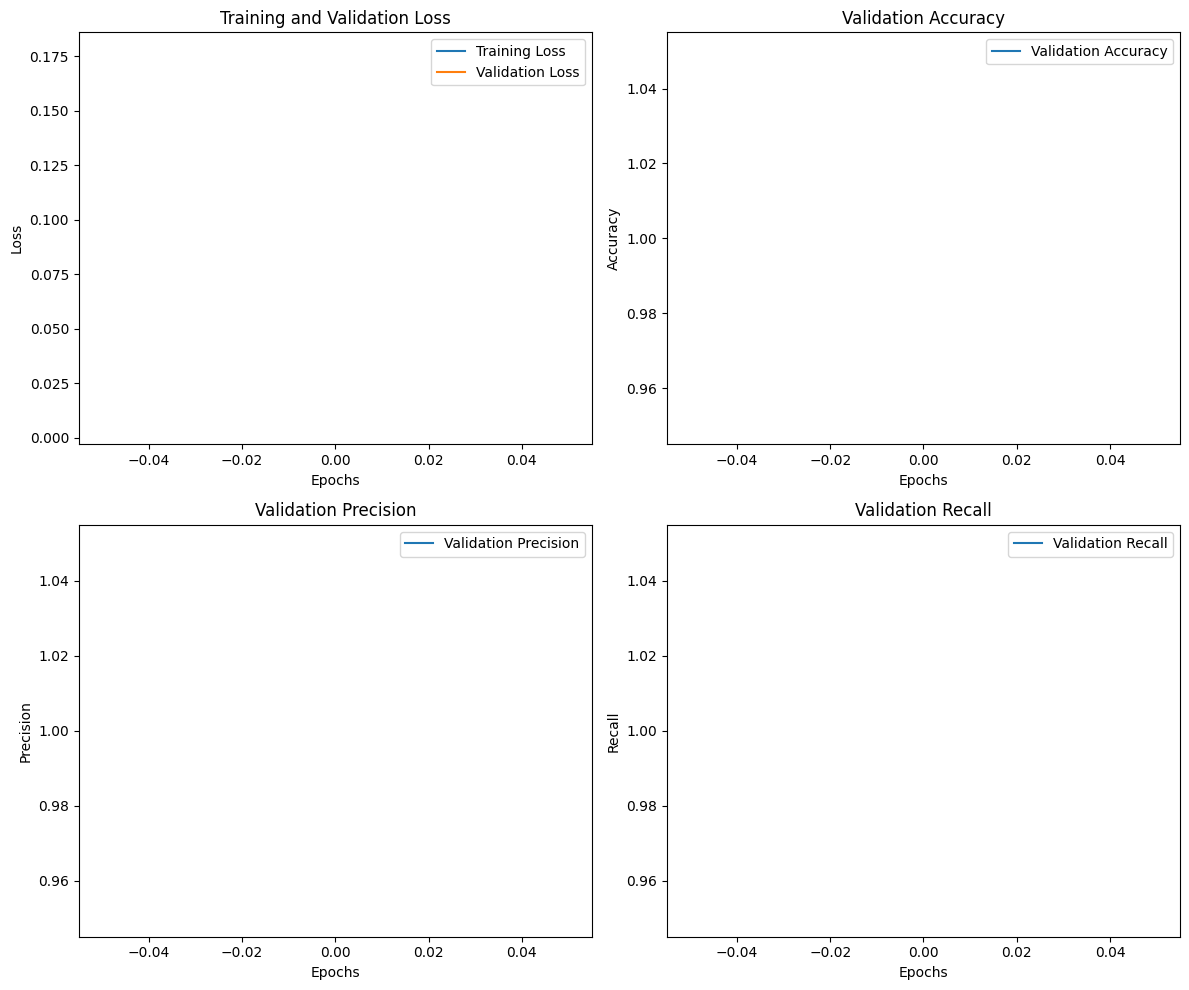

FOLD 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.04it/s]


Epoch [1/1], Training Loss: 0.2650, Validation Loss: 0.0037, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


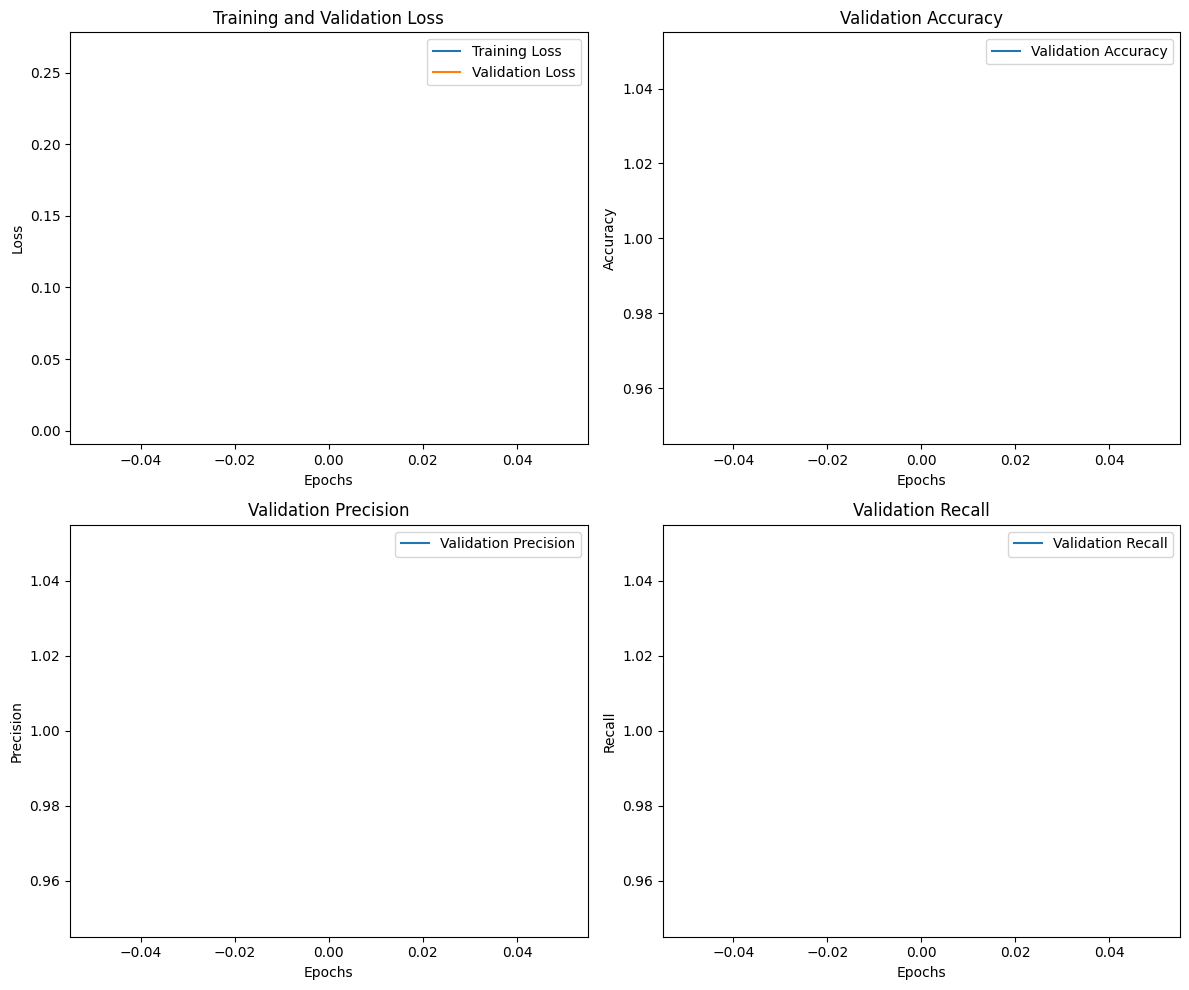

FOLD 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.04it/s]


Epoch [1/1], Training Loss: 0.1778, Validation Loss: 0.0011, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


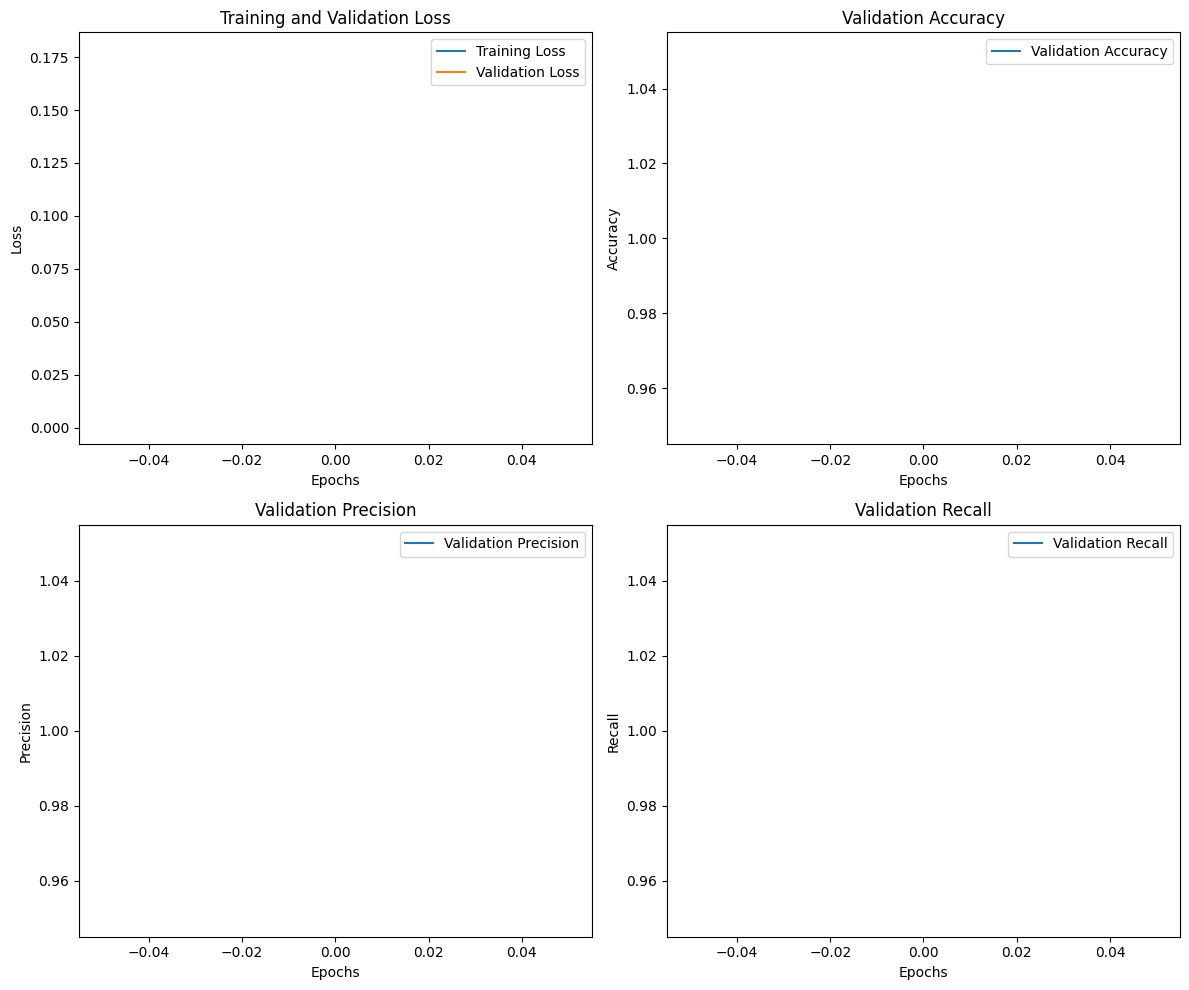

[1.0, 1.0, 1.0]
Can use the affirmative form.
FOLD 0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.04it/s]


Epoch [1/1], Training Loss: 0.2221, Validation Loss: 0.0021, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


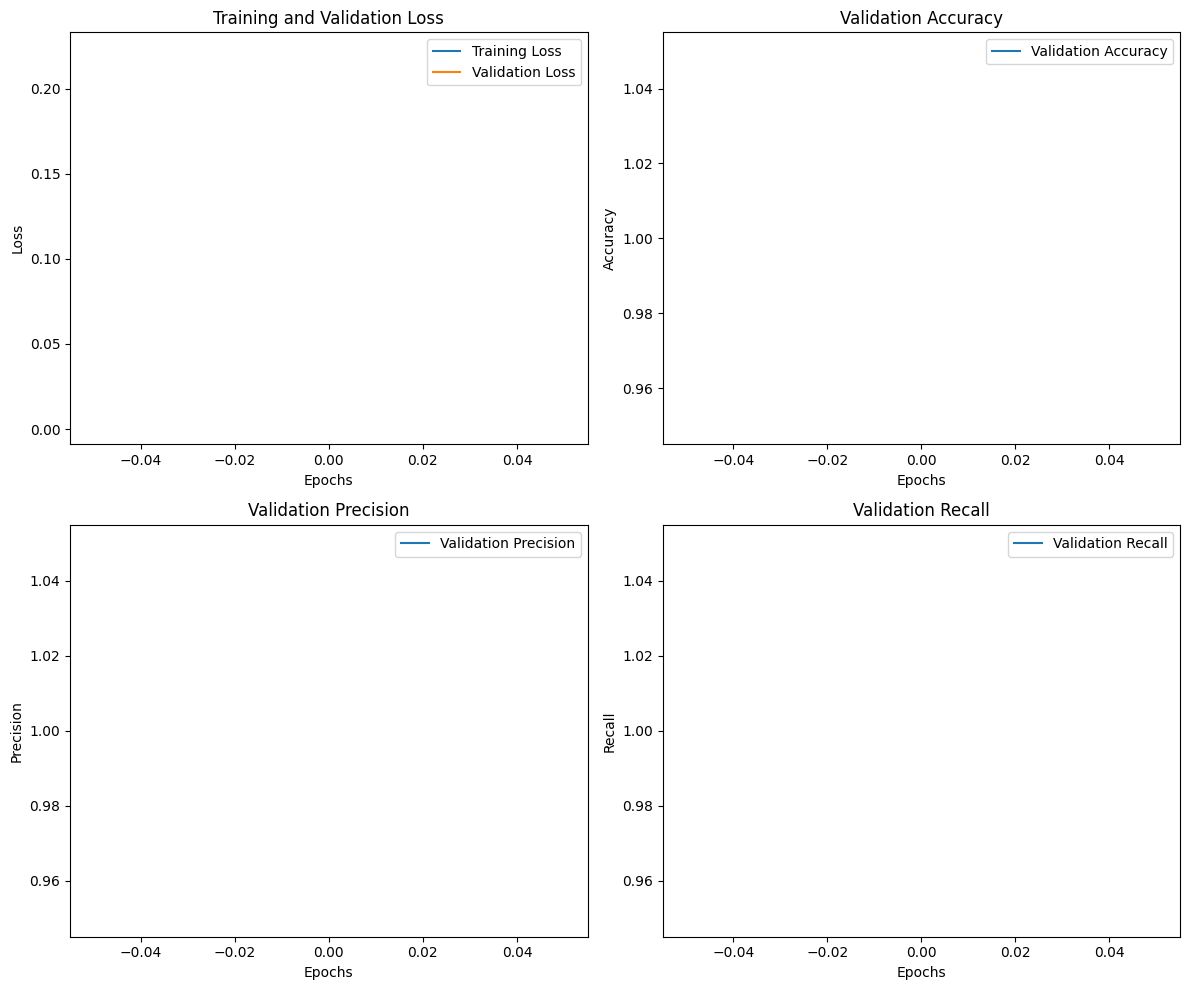

FOLD 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.01it/s]


Epoch [1/1], Training Loss: 0.1463, Validation Loss: 0.0009, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


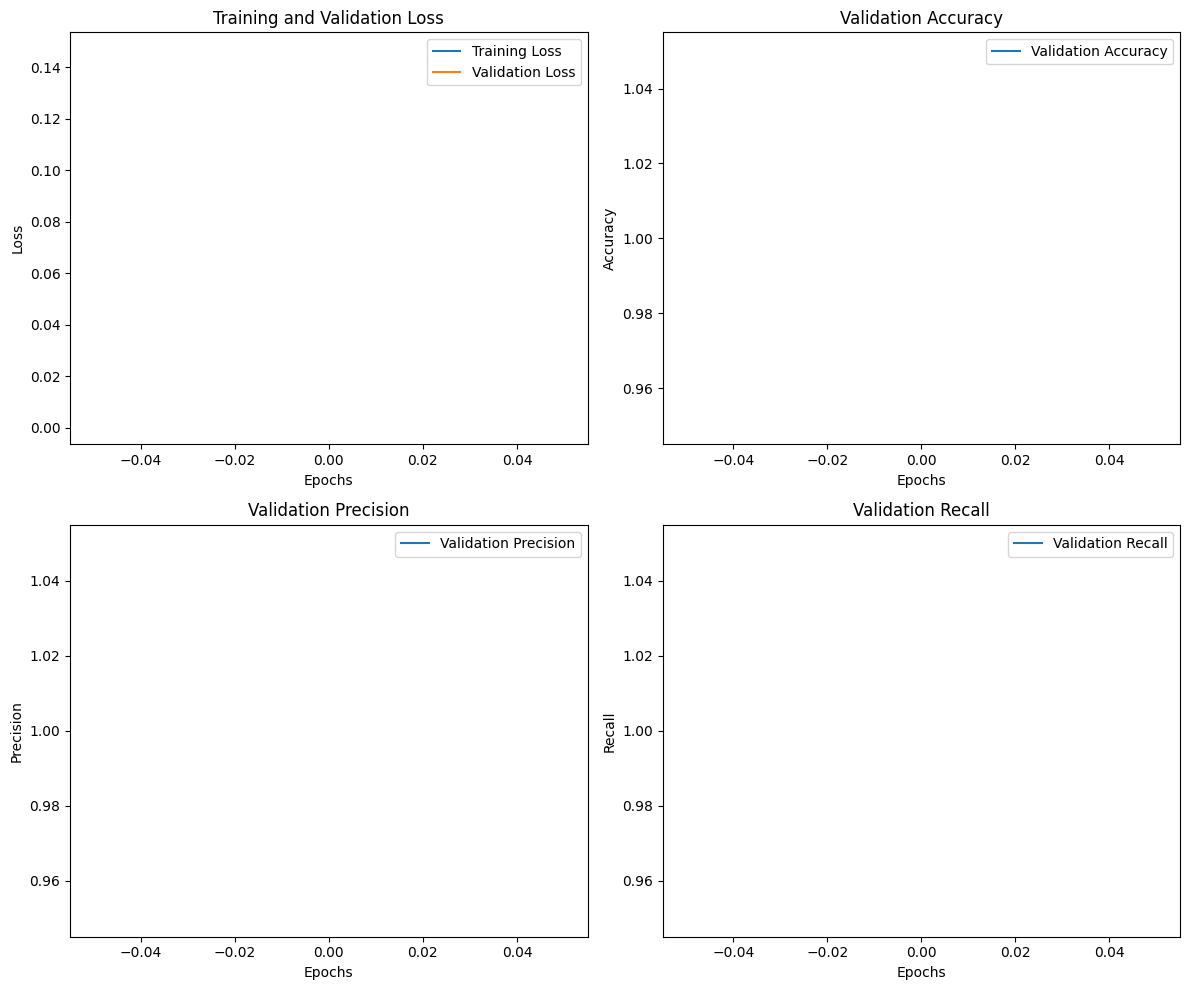

FOLD 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.02it/s]


Epoch [1/1], Training Loss: 0.2284, Validation Loss: 0.0018, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


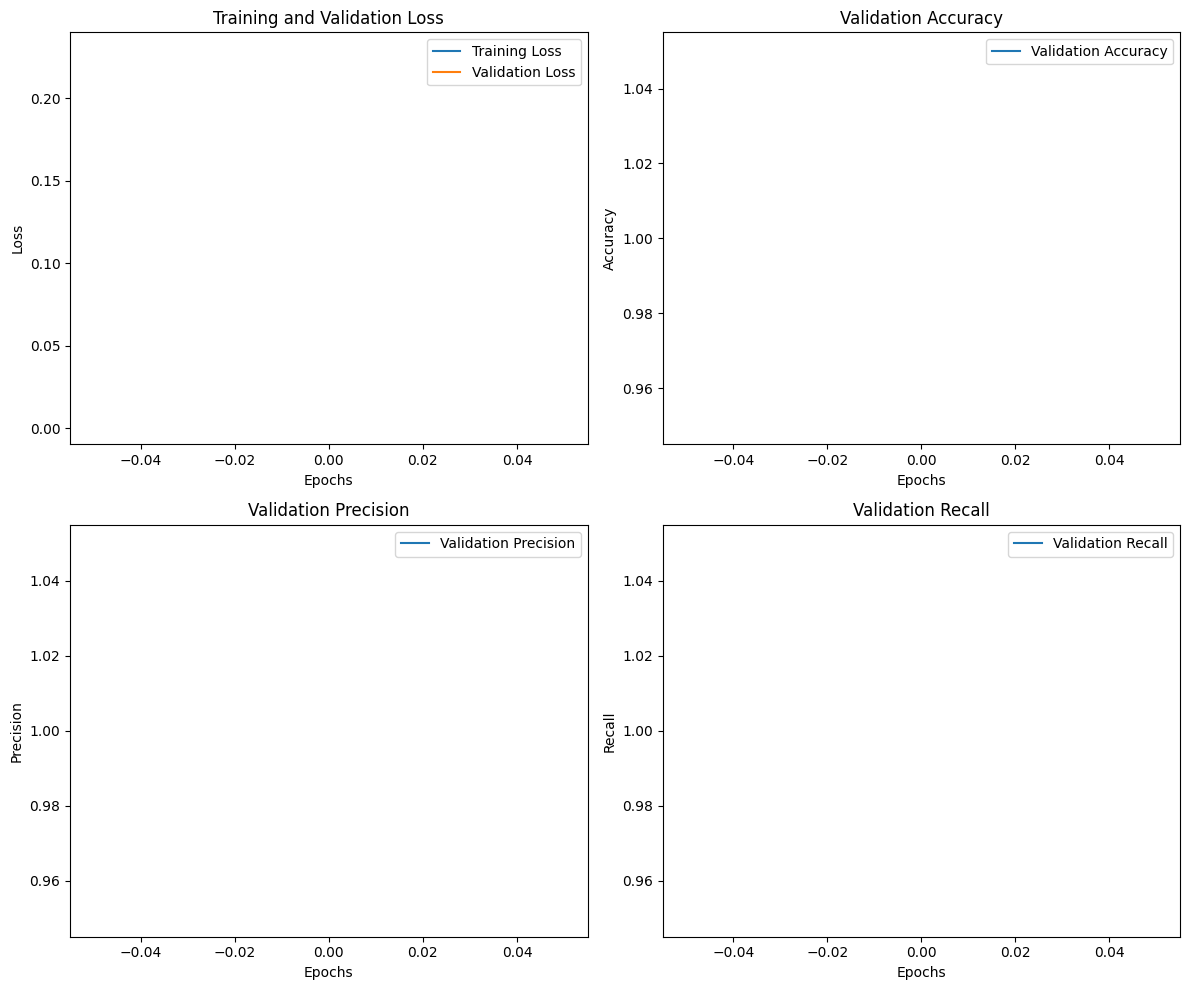

[1.0, 1.0, 1.0]
Can use a finite subordinate clause with 'because', after a main clause, to introduce reasons. 
FOLD 0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.04it/s]


Epoch [1/1], Training Loss: 0.2137, Validation Loss: 0.0039, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


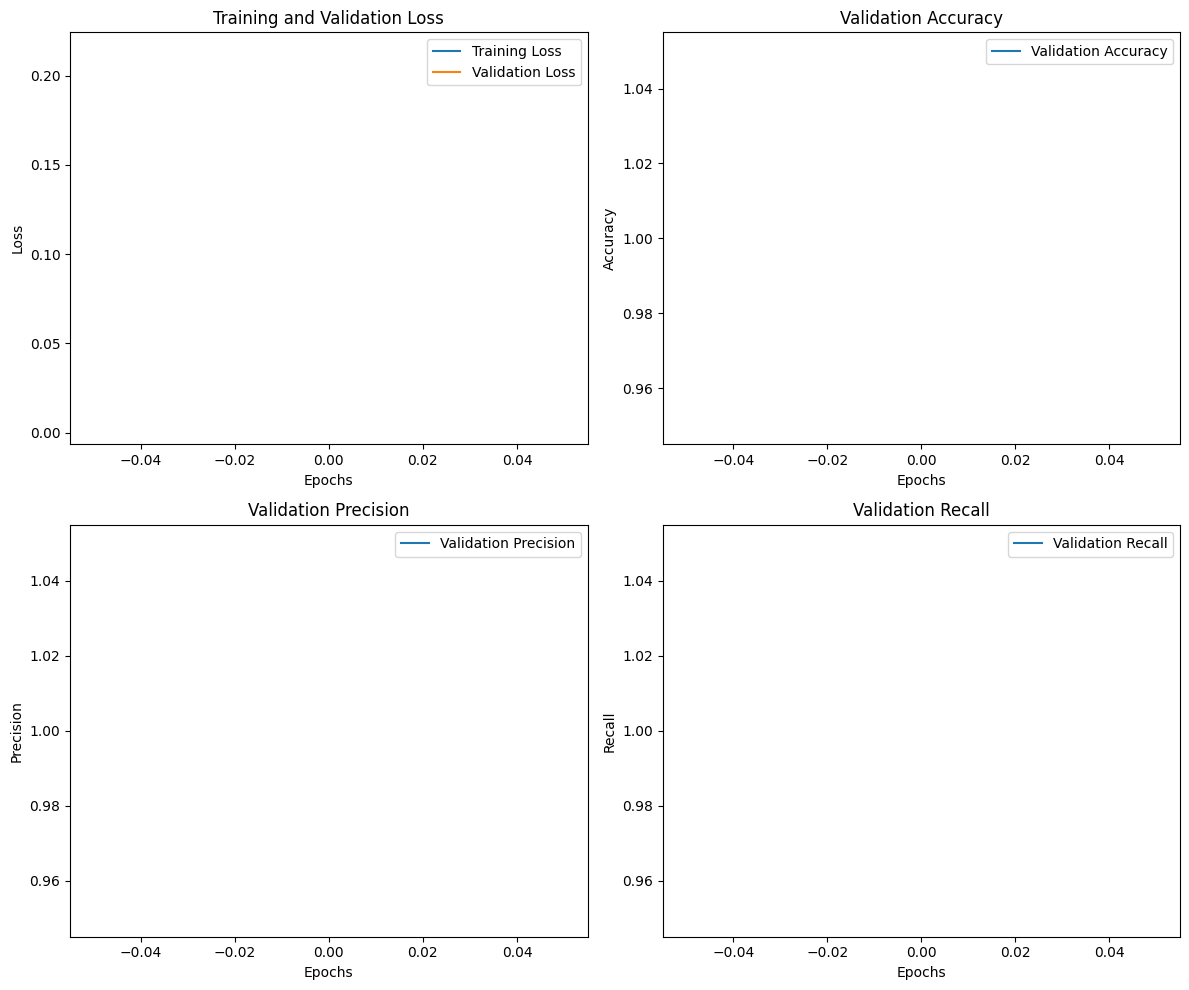

FOLD 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.05it/s]


Epoch [1/1], Training Loss: 0.2072, Validation Loss: 0.0015, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


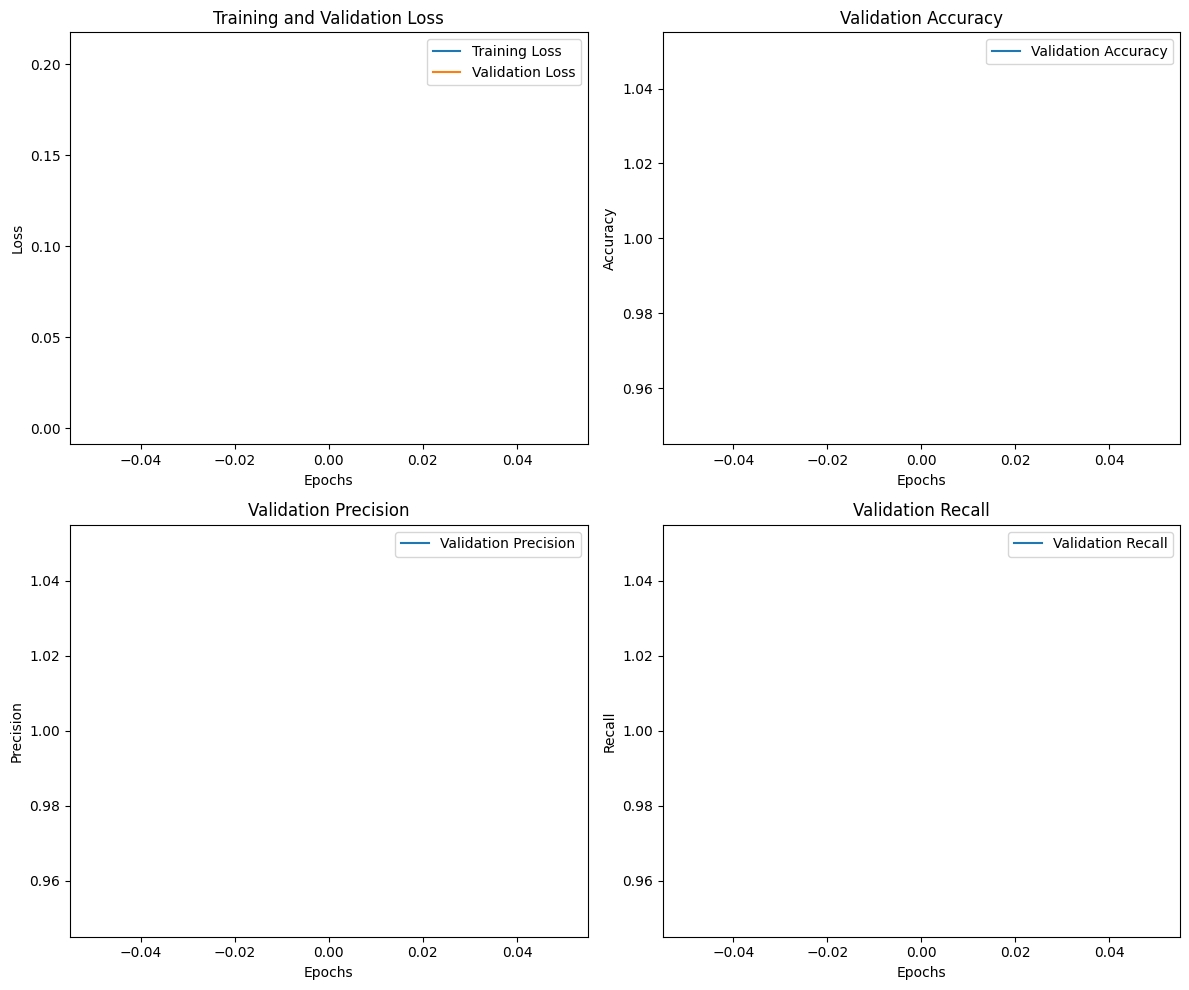

FOLD 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.04it/s]


Epoch [1/1], Training Loss: 0.1878, Validation Loss: 0.0013, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


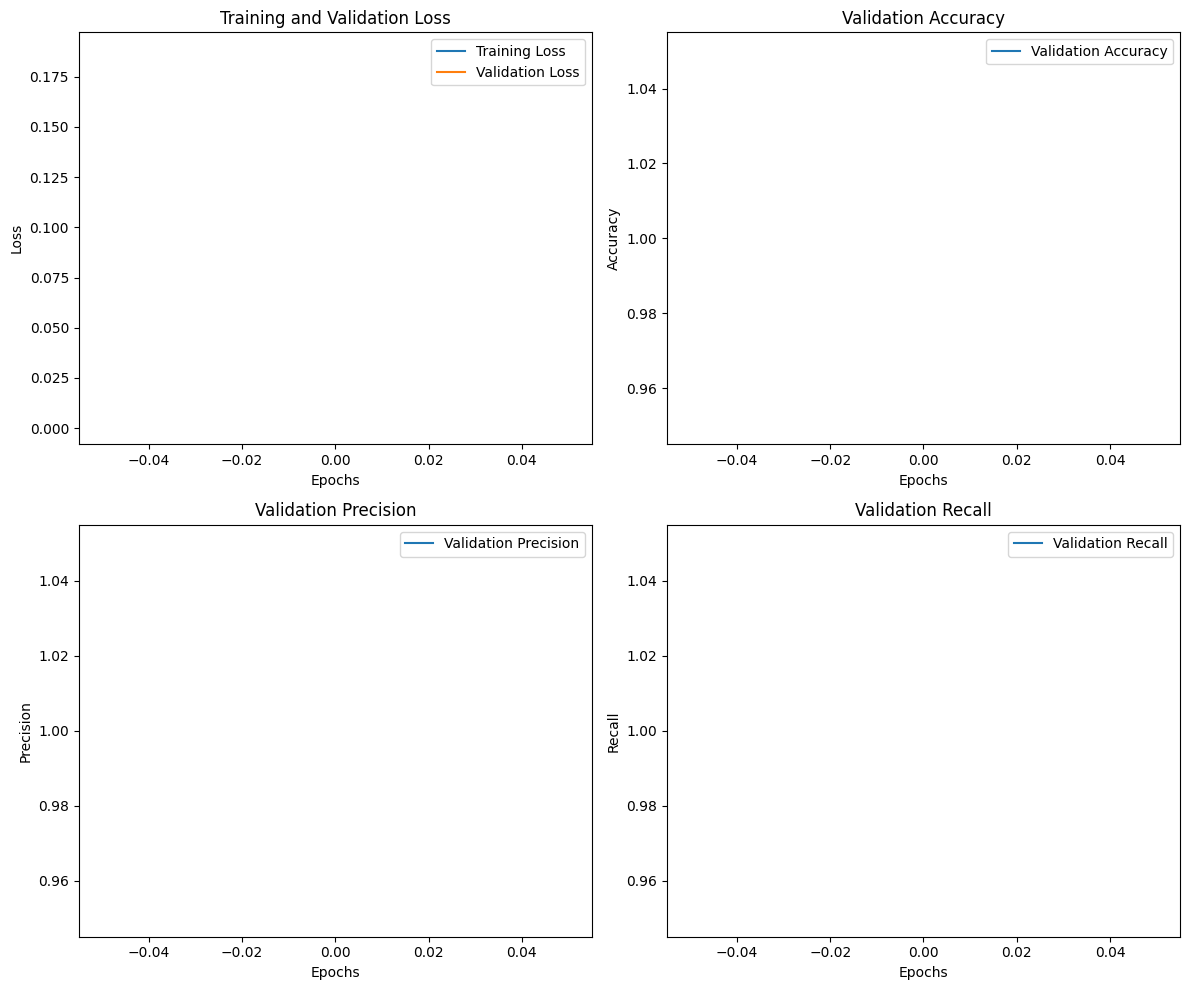

[1.0, 1.0, 1.0]
Can use no article before a limited range of singular, plural and uncountable nouns when referring to things in general. 
FOLD 0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.00it/s]


Epoch [1/1], Training Loss: 0.2973, Validation Loss: 0.0215, Validation Accuracy: 0.9970, Precision: 0.9940, Recall: 1.0000


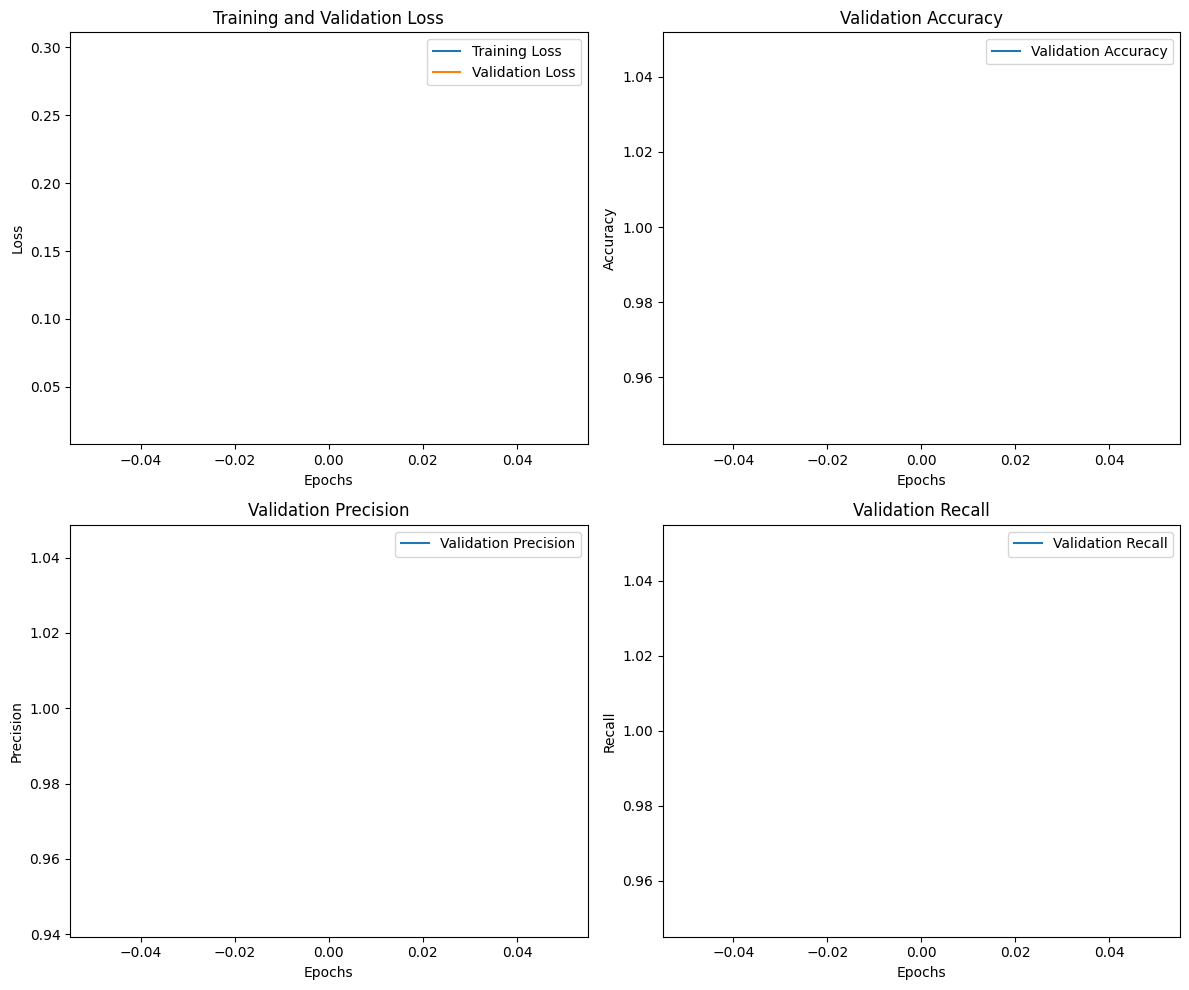

FOLD 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.01it/s]


Epoch [1/1], Training Loss: 0.2064, Validation Loss: 0.0022, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


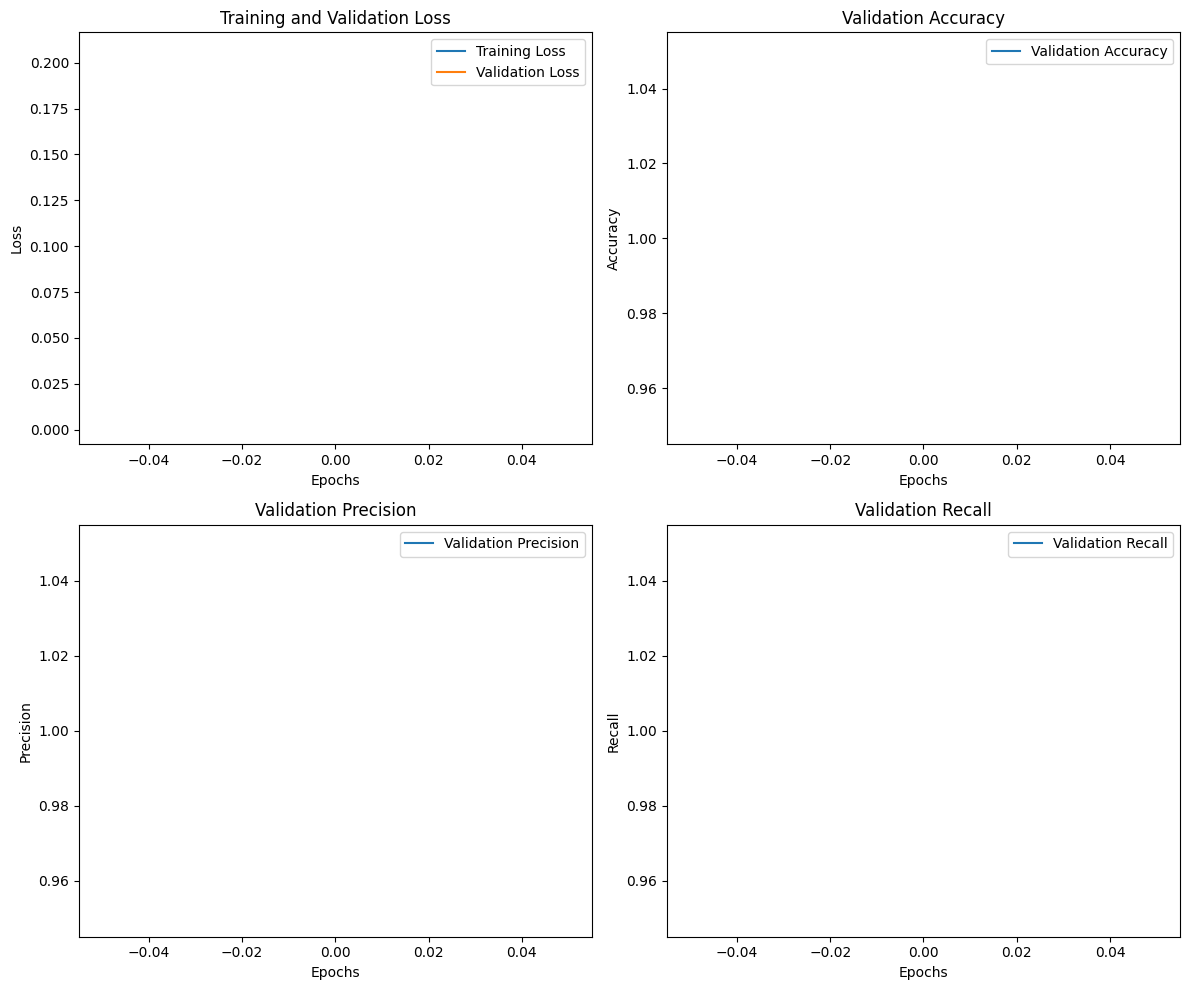

FOLD 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.00it/s]


Epoch [1/1], Training Loss: 0.2181, Validation Loss: 0.0192, Validation Accuracy: 0.9970, Precision: 0.9939, Recall: 1.0000


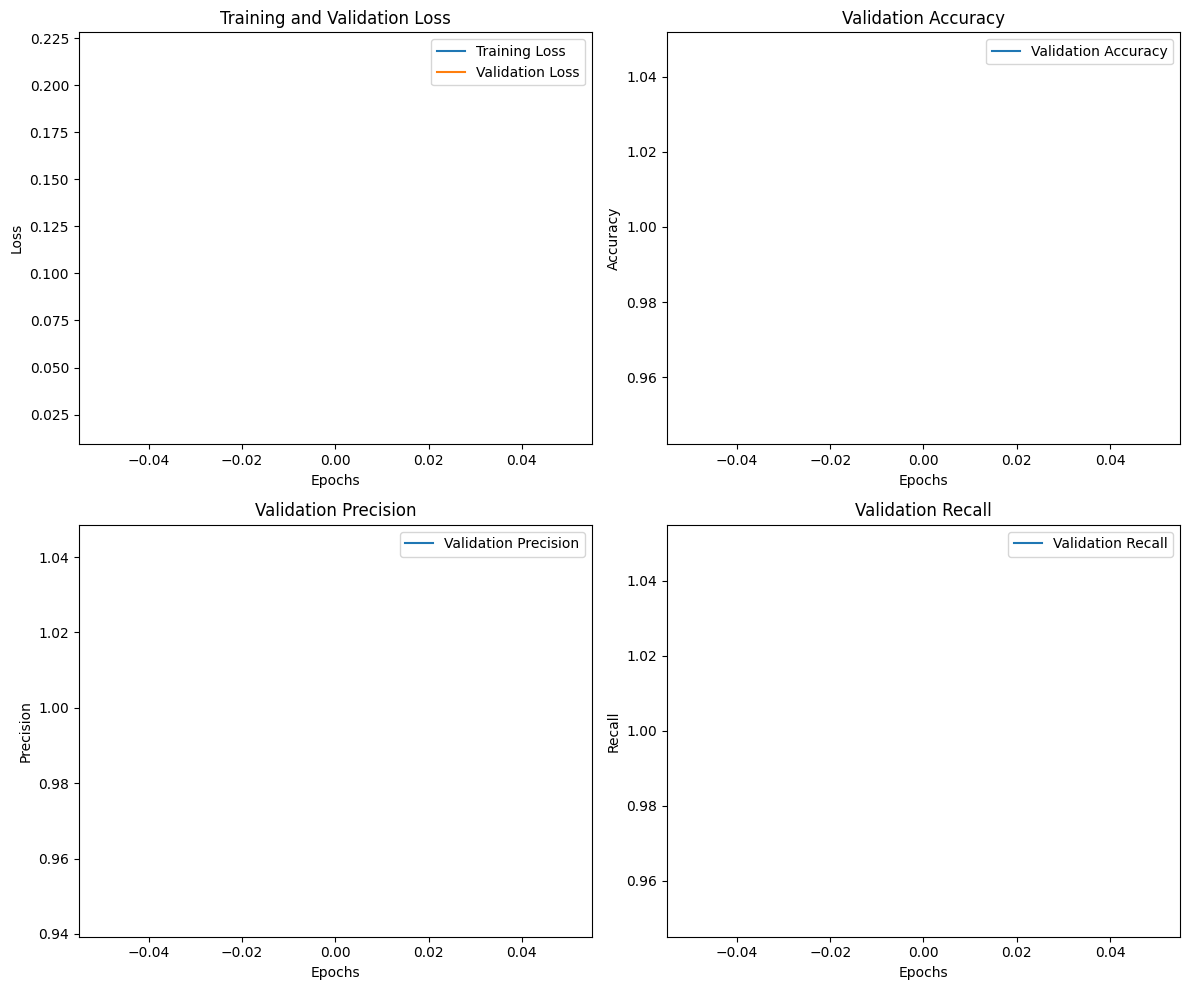

[0.9970059880239521, 1.0, 0.996996996996997]
Can use 'this' with time and date words to refer to 'the one that's coming'. 
FOLD 0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.03it/s]


Epoch [1/1], Training Loss: 0.1800, Validation Loss: 0.0026, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


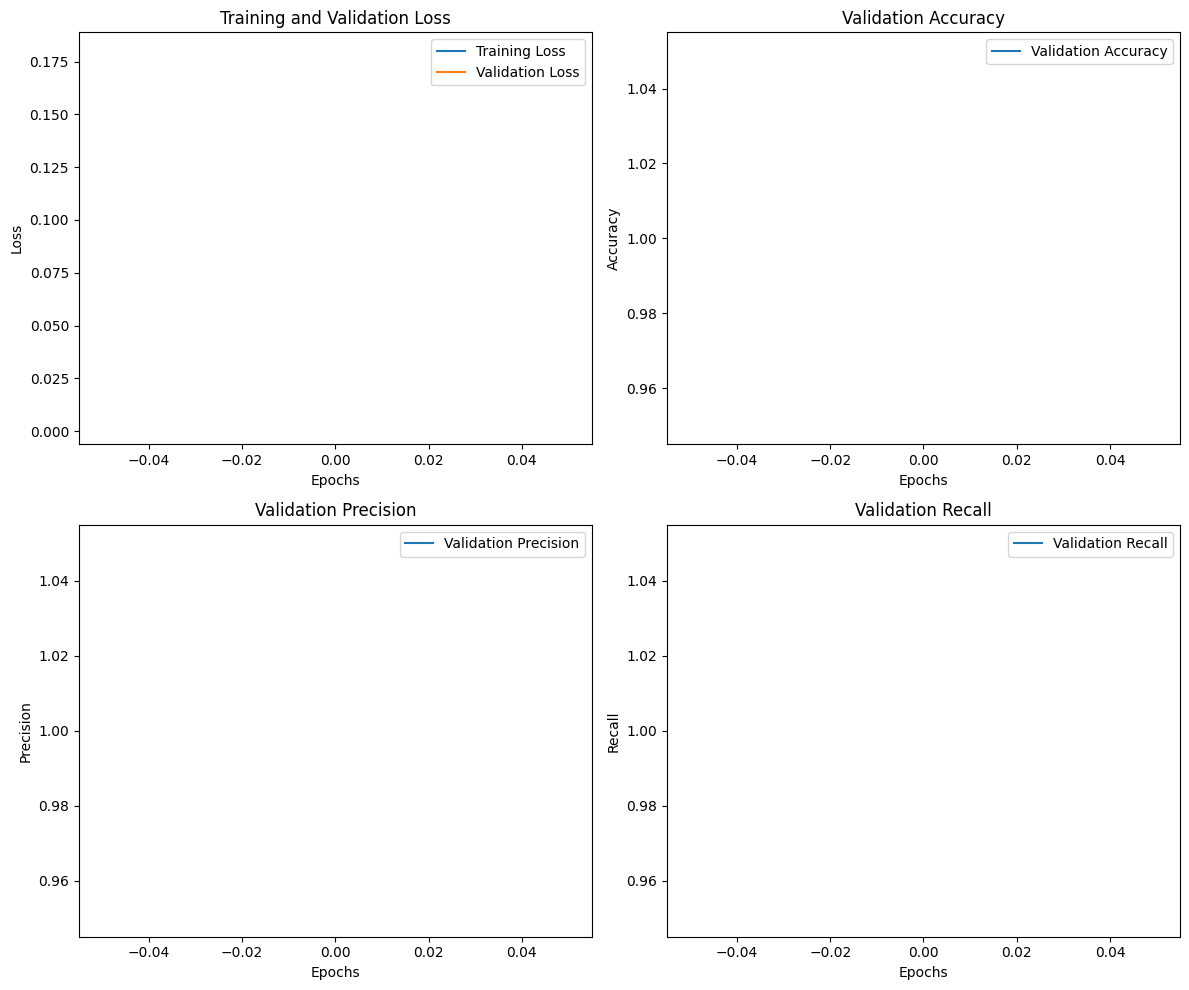

FOLD 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.02it/s]


Epoch [1/1], Training Loss: 0.1799, Validation Loss: 0.0194, Validation Accuracy: 0.9970, Precision: 0.9935, Recall: 1.0000


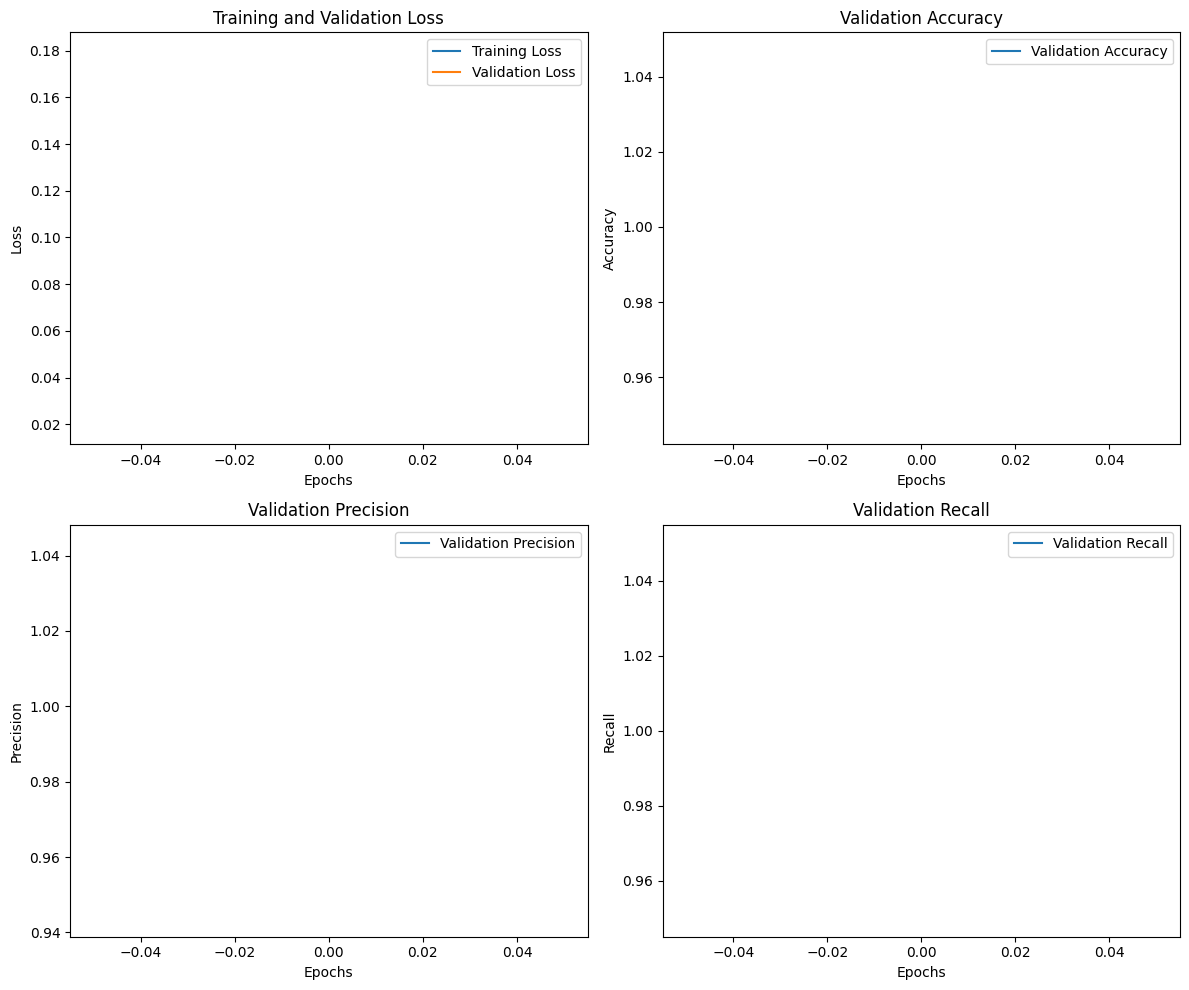

FOLD 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.02it/s]


Epoch [1/1], Training Loss: 0.2281, Validation Loss: 0.0017, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


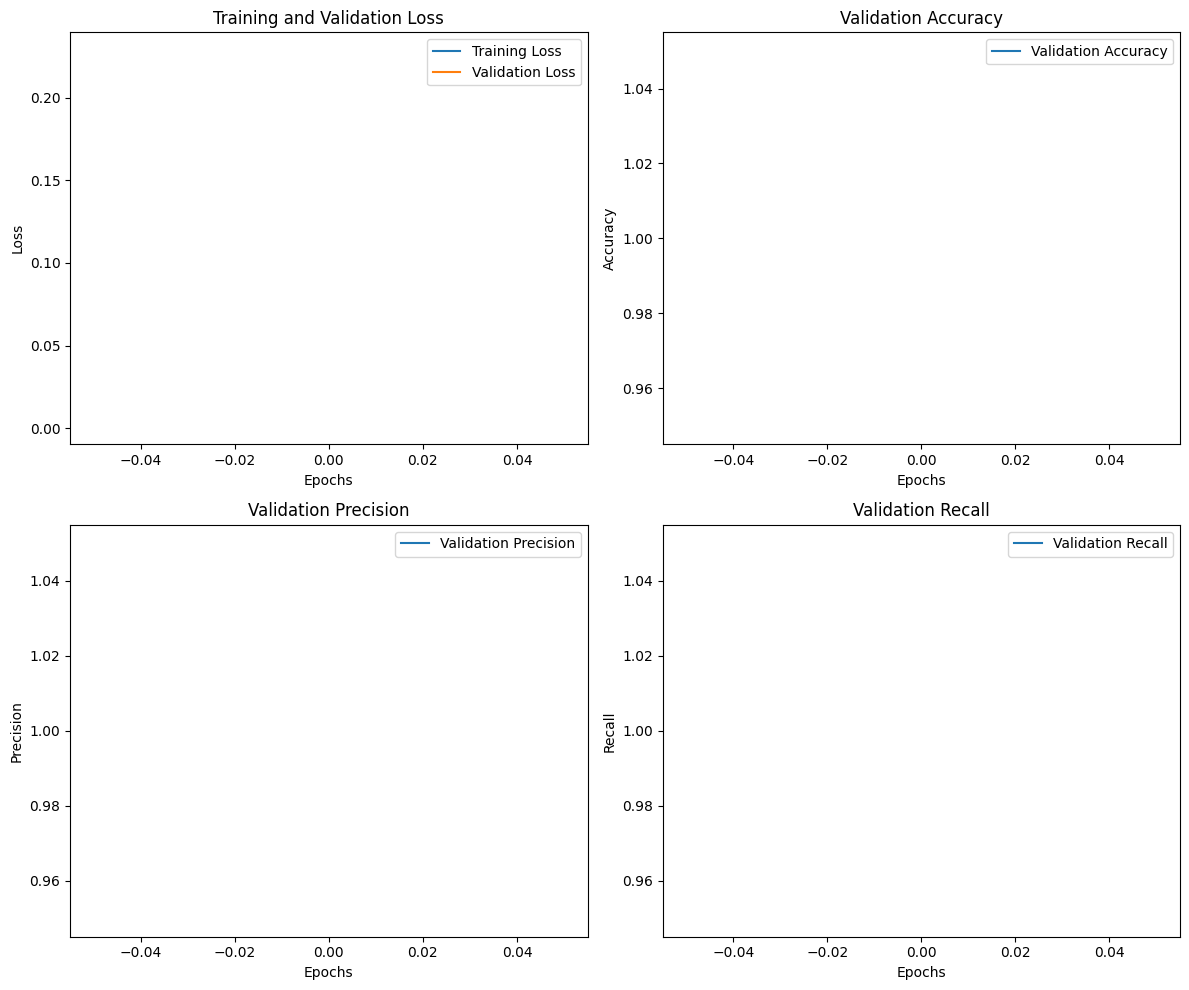

[1.0, 0.996996996996997, 1.0]
Can use the present continuous with a limited range of verbs to talk about situations and events in progress.
FOLD 0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.02it/s]


Epoch [1/1], Training Loss: 0.2355, Validation Loss: 0.0277, Validation Accuracy: 0.9940, Precision: 0.9881, Recall: 1.0000


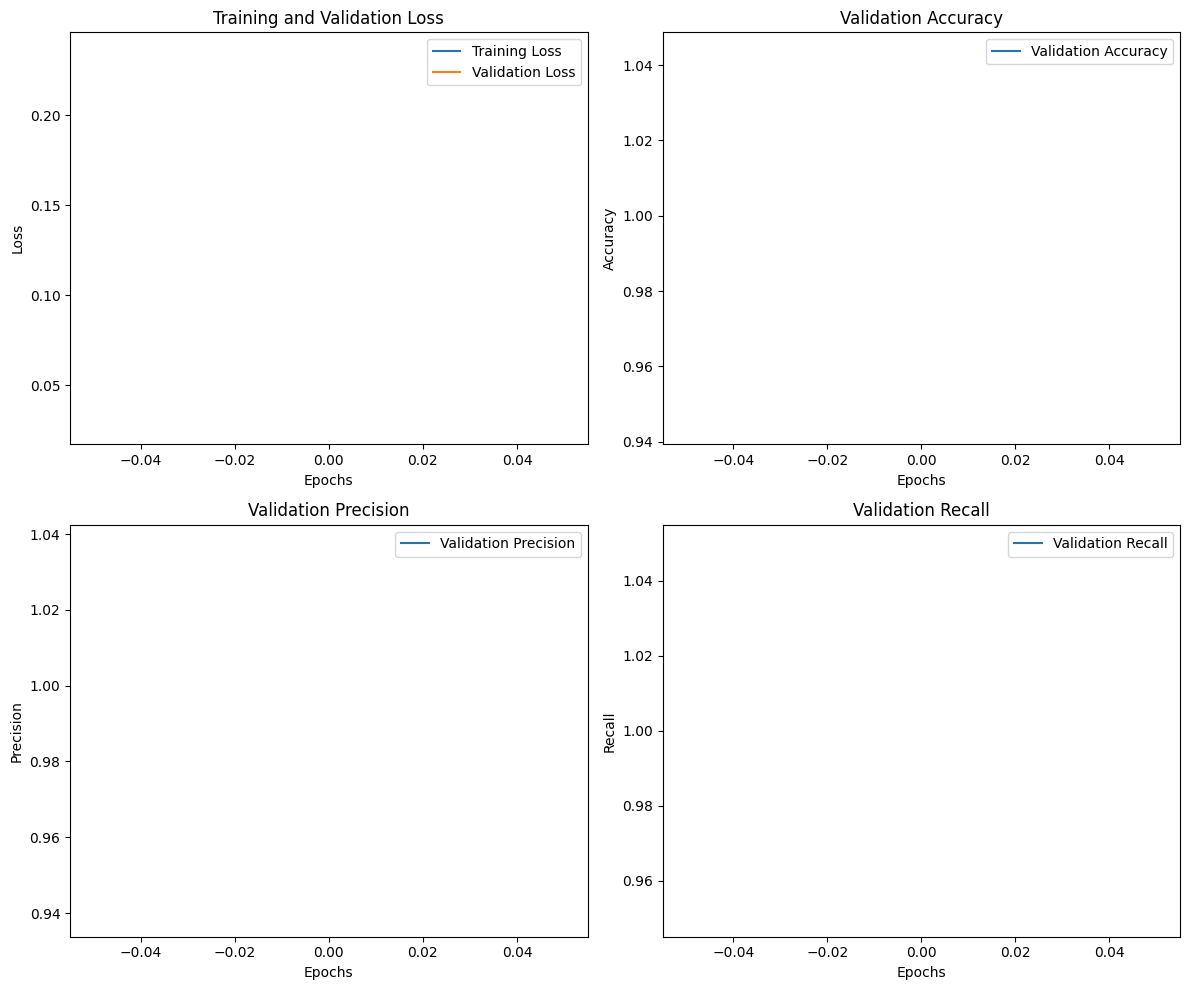

FOLD 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.02it/s]


Epoch [1/1], Training Loss: 0.2194, Validation Loss: 0.0177, Validation Accuracy: 0.9970, Precision: 0.9938, Recall: 1.0000


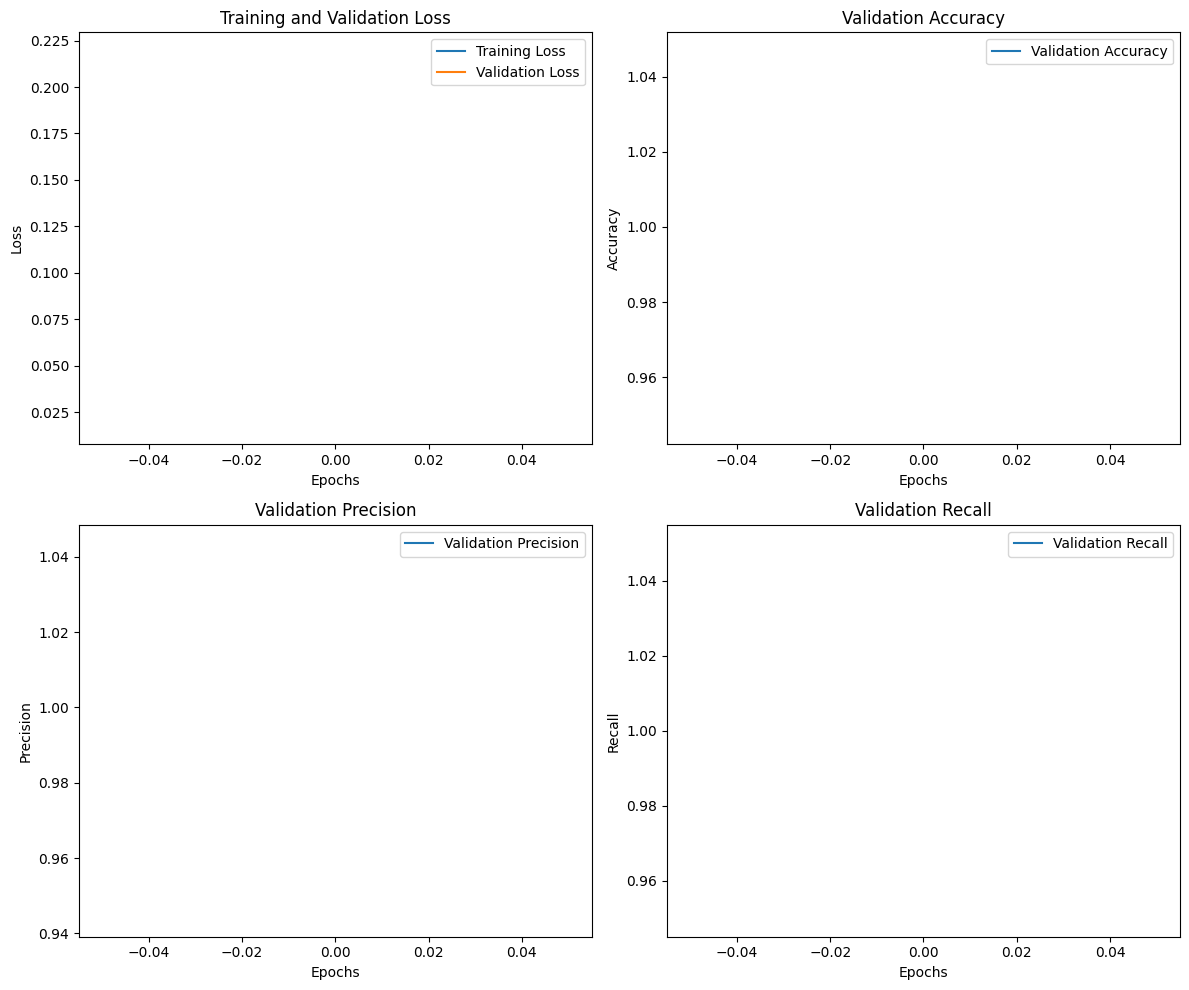

FOLD 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  3.98it/s]


Epoch [1/1], Training Loss: 0.2431, Validation Loss: 0.0034, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


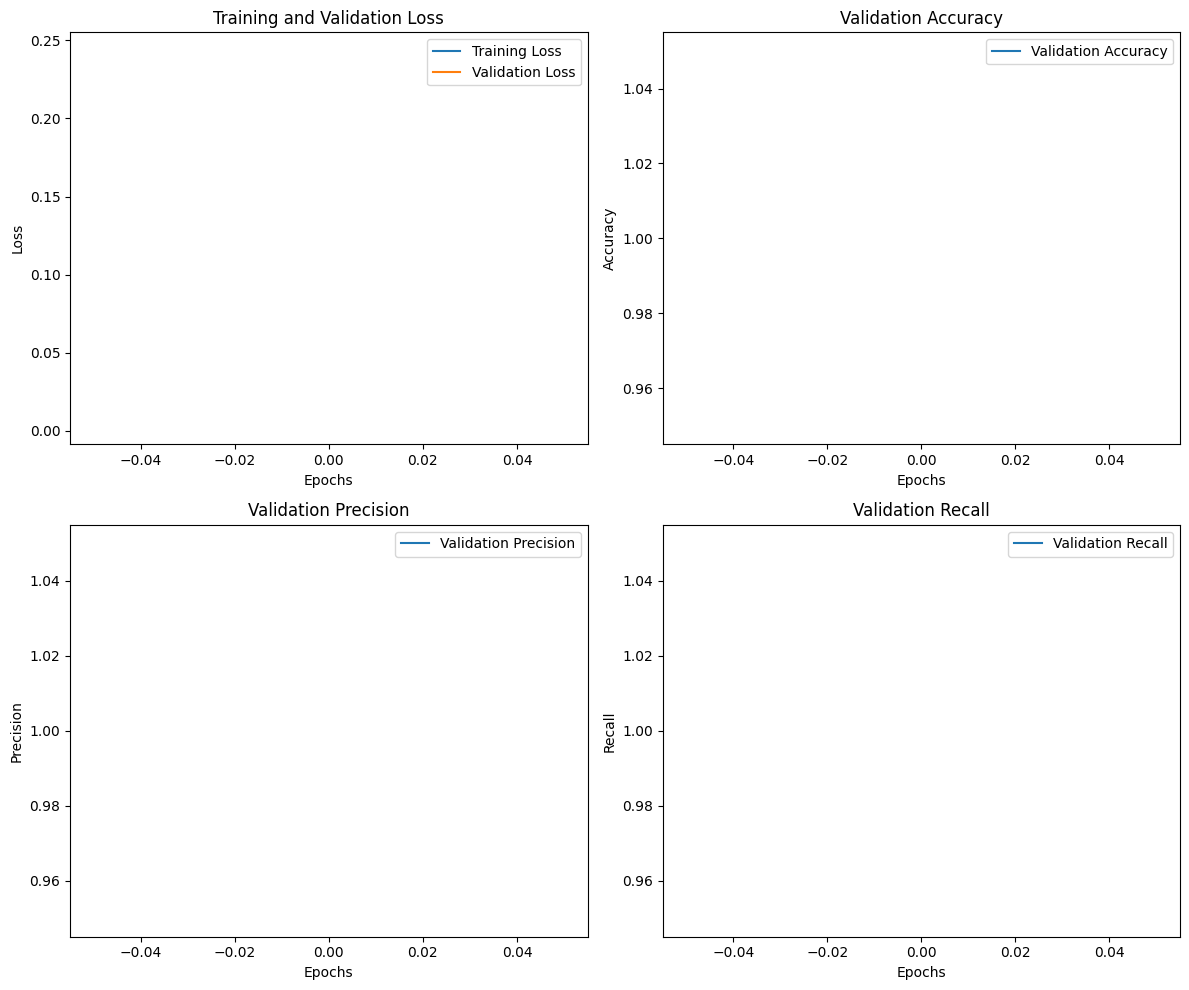

[0.9940119760479041, 0.996996996996997, 1.0]
Can use 'can' to talk about possibility.
FOLD 0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.00it/s]


Epoch [1/1], Training Loss: 0.3000, Validation Loss: 0.0194, Validation Accuracy: 0.9970, Precision: 0.9941, Recall: 1.0000


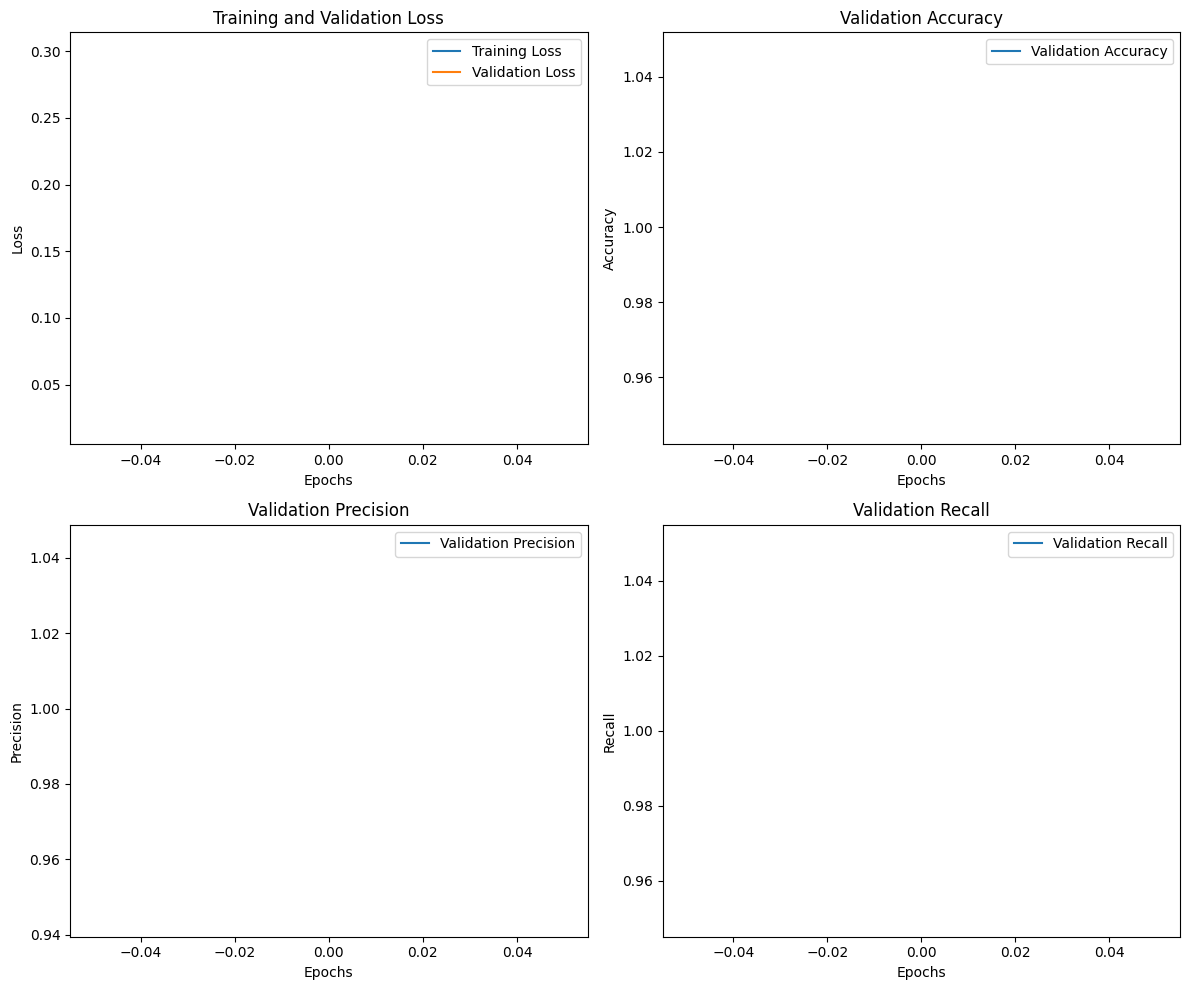

FOLD 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.00it/s]


Epoch [1/1], Training Loss: 0.3012, Validation Loss: 0.0074, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


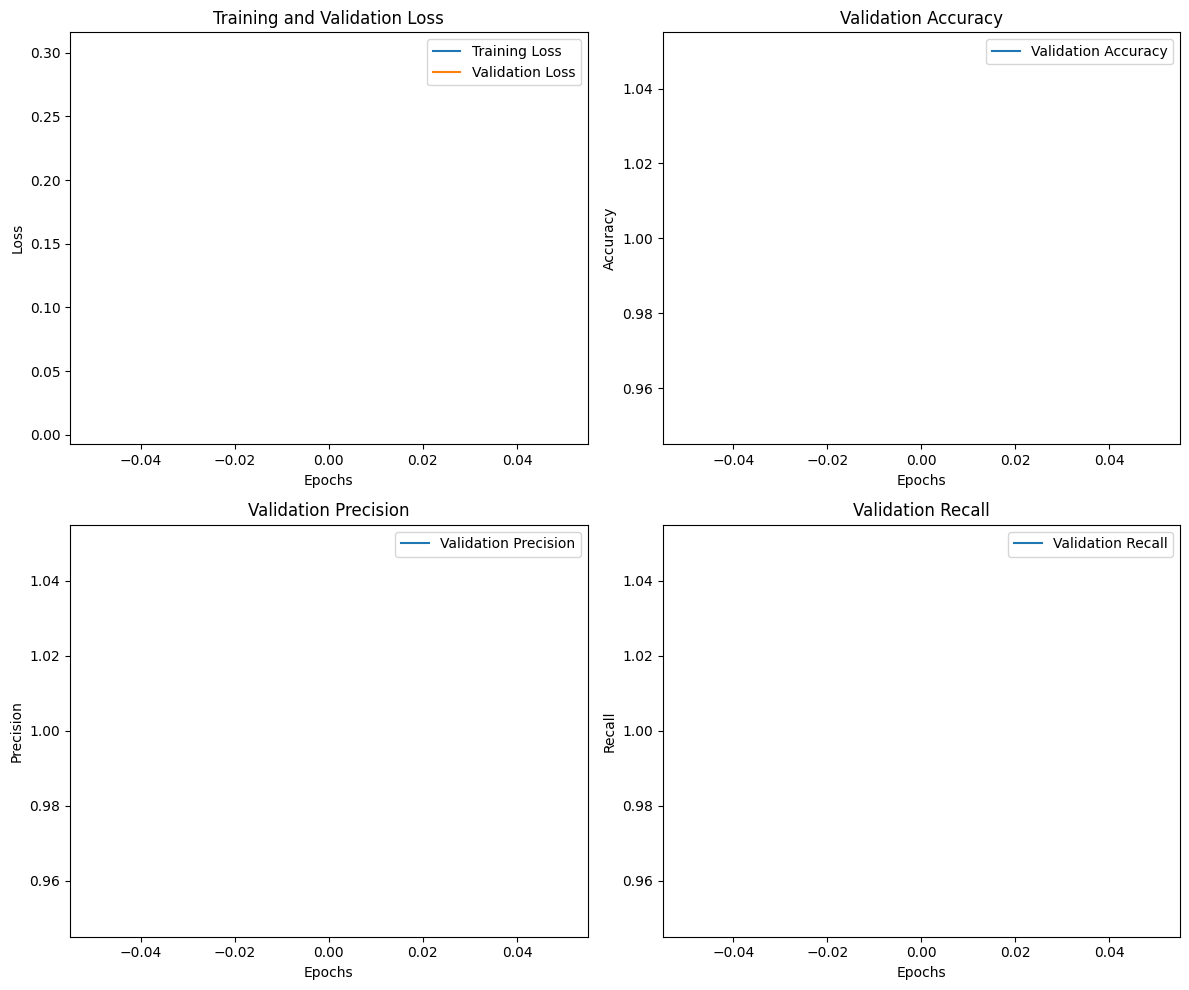

FOLD 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.00it/s]


Epoch [1/1], Training Loss: 0.2280, Validation Loss: 0.0021, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


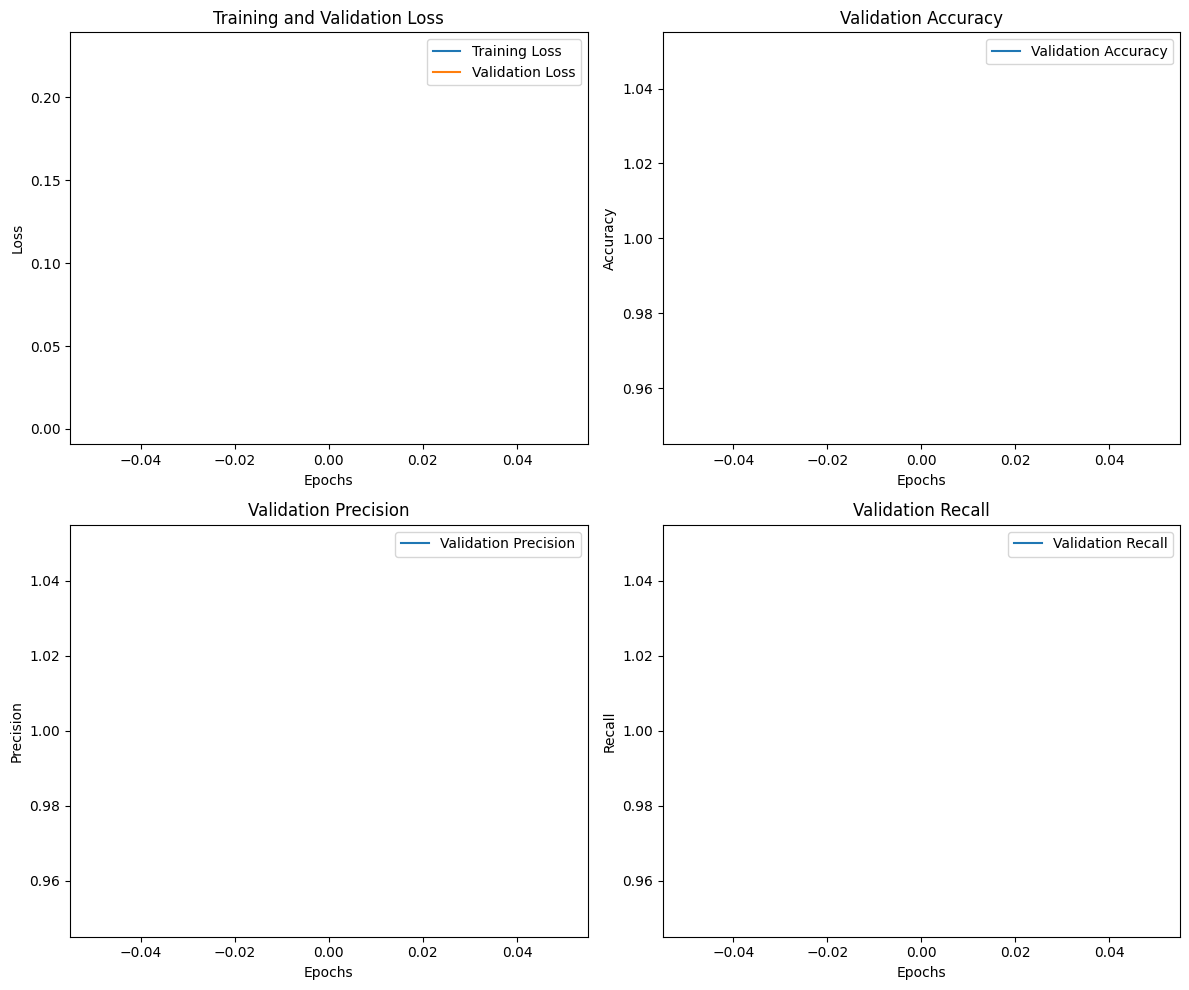

[0.9970059880239521, 1.0, 1.0]
Can use the negative forms 'will not' and 'won't'.
FOLD 0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.02it/s]


Epoch [1/1], Training Loss: 0.2879, Validation Loss: 0.0022, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


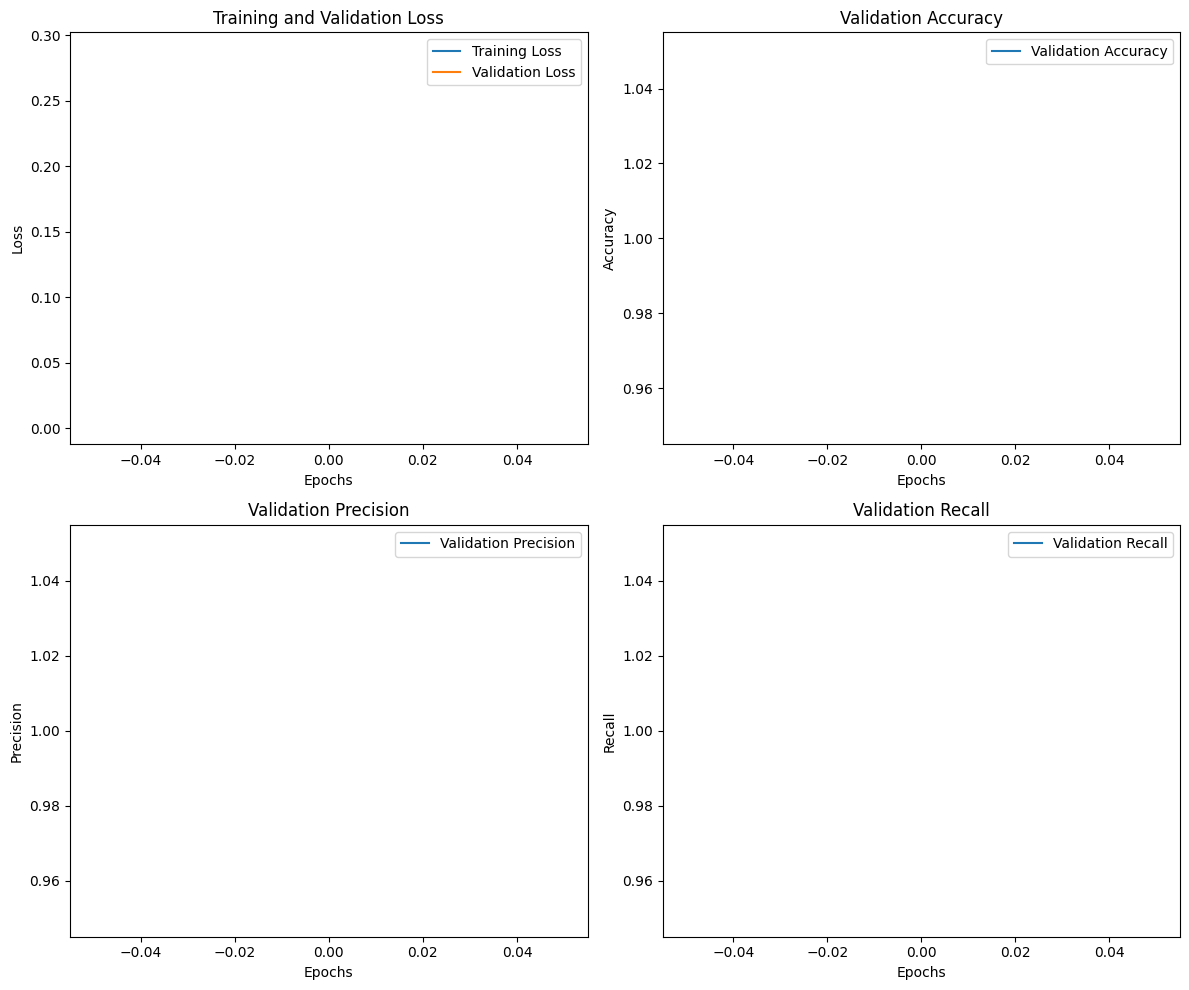

FOLD 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.01it/s]


Epoch [1/1], Training Loss: 0.2523, Validation Loss: 0.0018, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


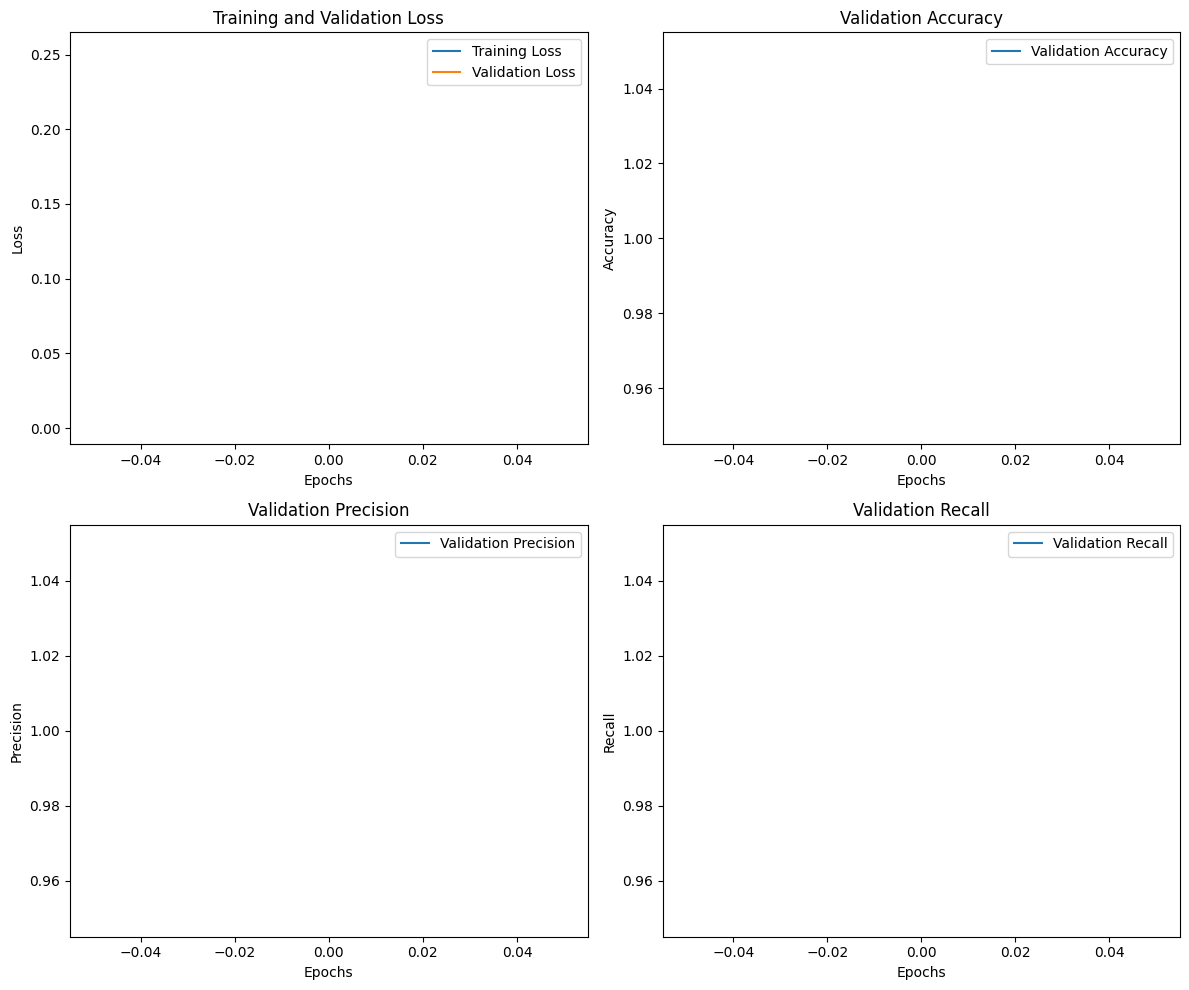

FOLD 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.02it/s]


Epoch [1/1], Training Loss: 0.2522, Validation Loss: 0.0022, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


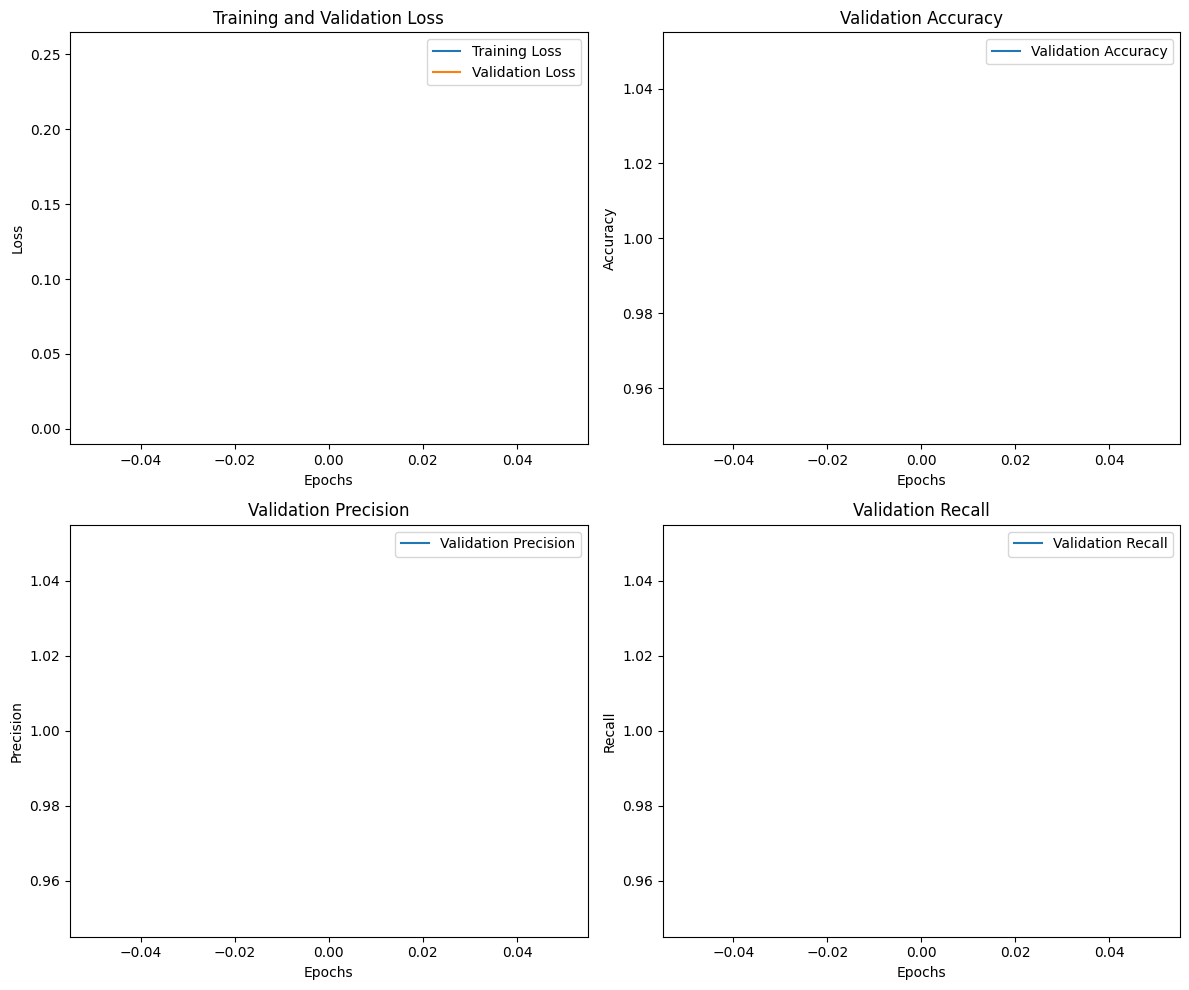

[1.0, 1.0, 1.0]
Can form superlative adjectives using the suffix '-st' to adjectives ending in '–e'.
FOLD 0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.03it/s]


Epoch [1/1], Training Loss: 0.2703, Validation Loss: 0.0025, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


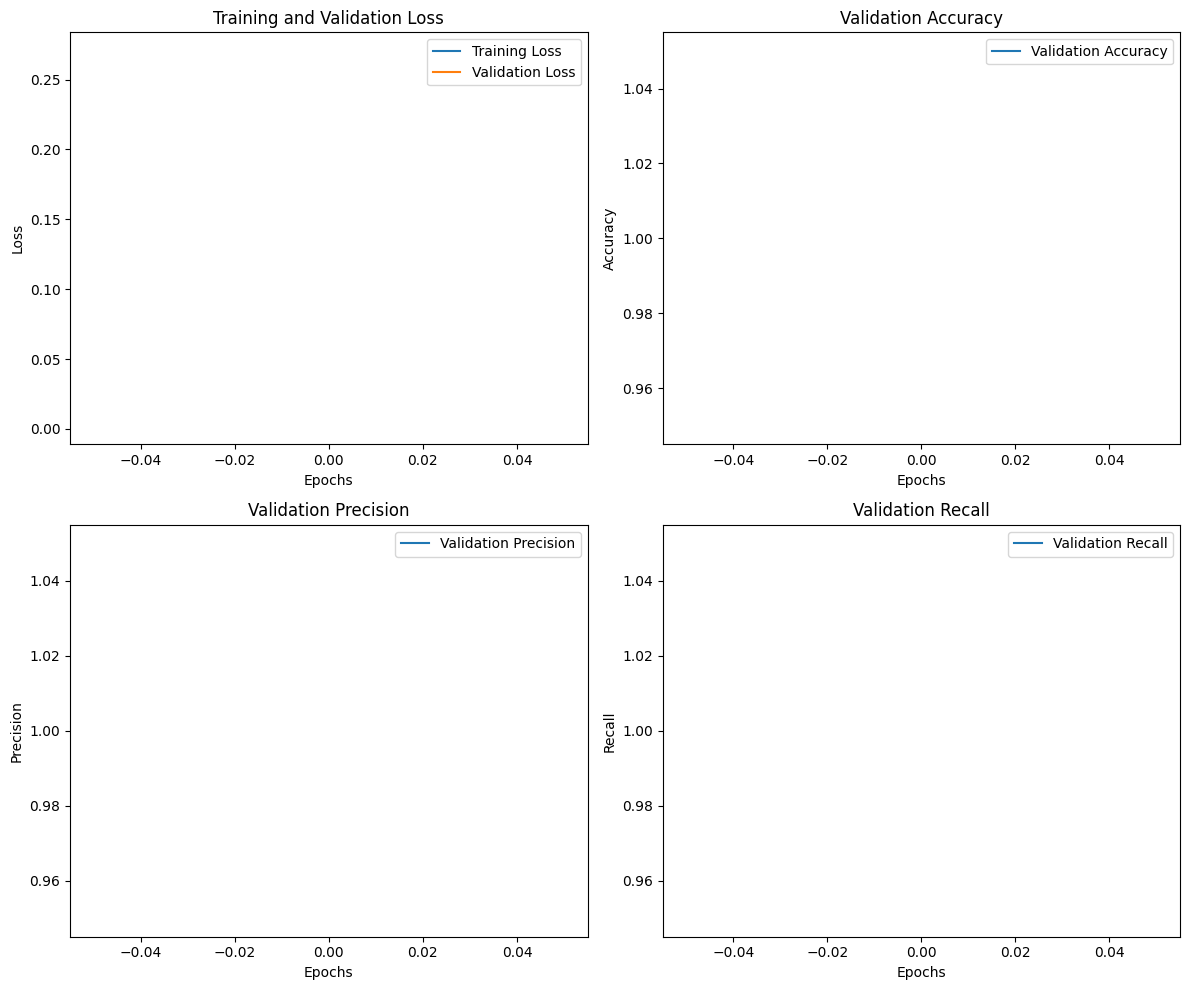

FOLD 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.01it/s]


Epoch [1/1], Training Loss: 0.2066, Validation Loss: 0.0033, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


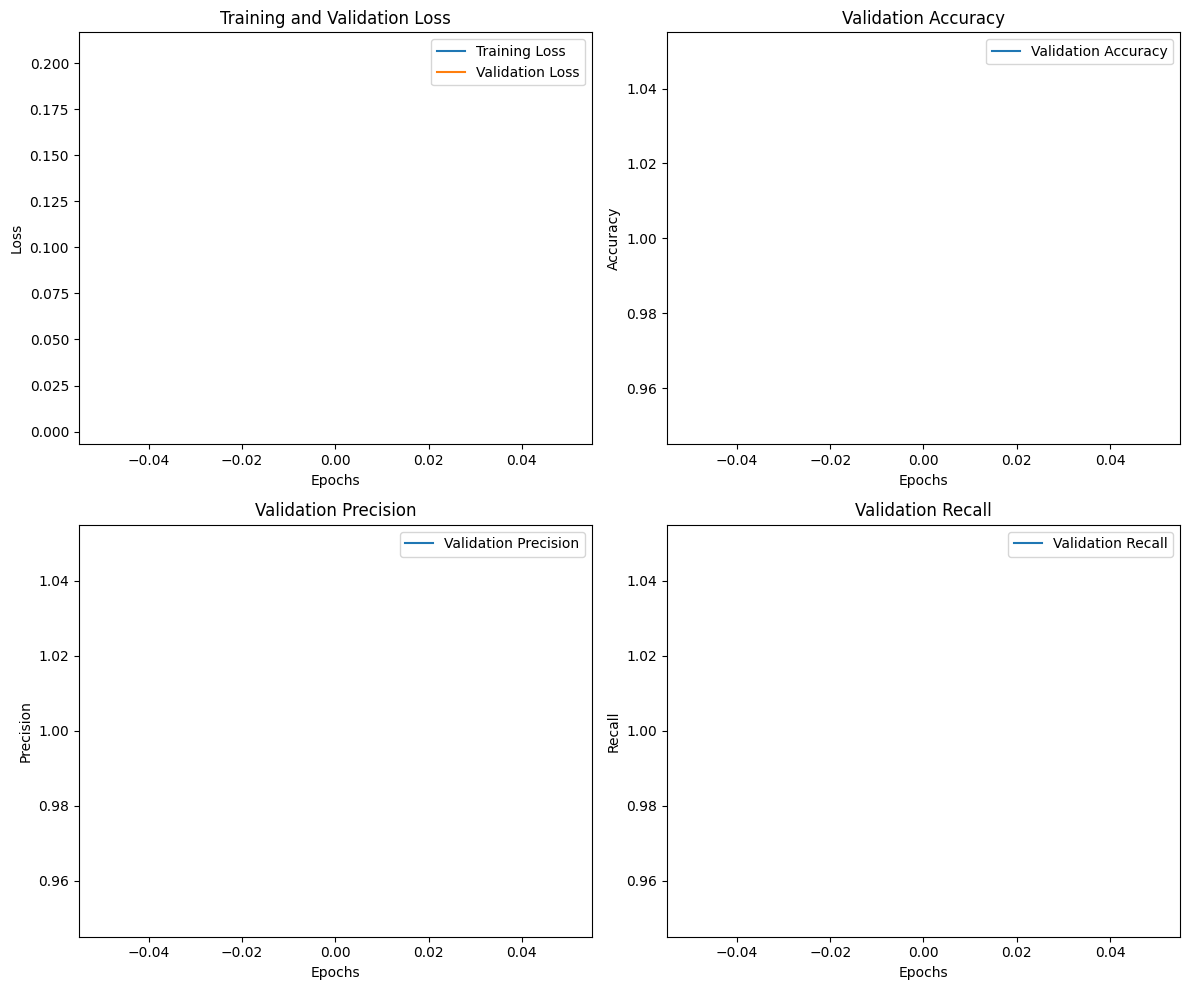

FOLD 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.02it/s]


KeyboardInterrupt: 

In [6]:
def CV_train(construction, k_folds = 3, batch_size=32, random_negatives=True):
    print(construction['Can-do statement'])
    dataset = get_dataset(row, tokenizer, max_len)

    accuracies = []
    precisions = []
    recalls = []

    kfold = KFold(n_splits=k_folds, shuffle=True)
    for fold, (train_ids, test_ids) in enumerate(kfold.split(list(range(len(dataset))))):
        print(f'FOLD {fold}')

        # Prepare data for fold
        trainloader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_ids))
        testloader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_ids))

        # Reinitialize model
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased').to(device)

        # Train model
        model, val_accuracy, precision, recall = train(model, trainloader, testloader, plots=False, verbose=False, num_epochs=1)

        # Store metrics
        accuracies.append(val_accuracy)
        precisions.append(precision)
        recalls.append(recall)

    return accuracies, precisions, recalls

results = []
for idx, construction in df.iterrows():
    accuracies, precisions, recalls = CV_train(construction)
    print(accuracies)
    results.append({'Construction': construction['Level'] + '-' + str(construction['#']), 
                    'Accuracies': accuracies, 
                    'Precisions': precisions, 
                    'Recalls': recalls})
results_df = pd.DataFrame(results)

In [11]:
results_df.to_json('../dat/classification_results_54.json')

## Analyze results

In [45]:
results_df = pd.read_json('../dat/classification_results_54.json')

Add the type to the construction, again.

In [46]:
egp = pd.read_csv('../dat/egponline.csv')

results_df['Construction_ID'] = results_df['Construction'].apply(lambda x: x[3:]).astype("int64")
merged_df = results_df.merge(egp, left_on='Construction_ID', right_on='#', how='left')
results_df['type'] = merged_df['type']

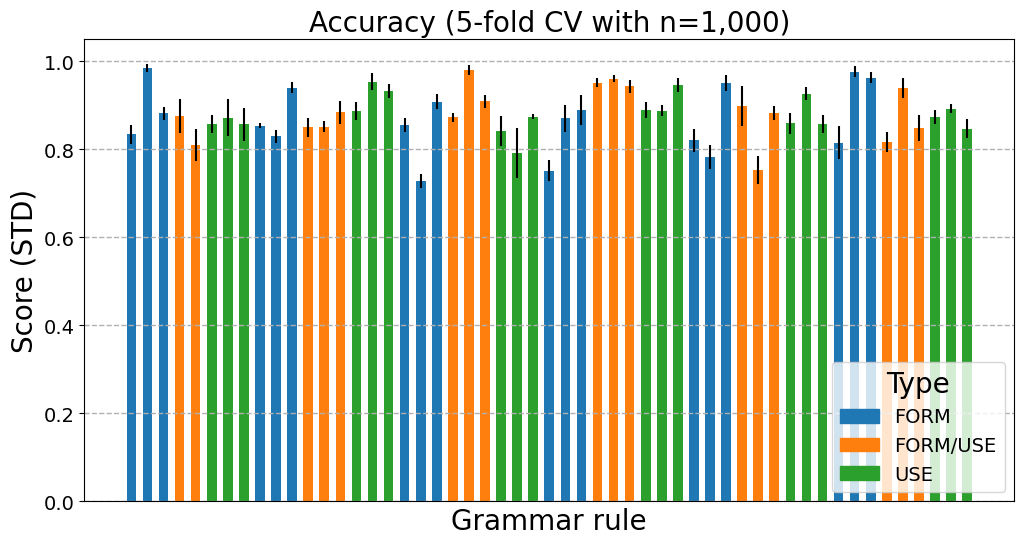

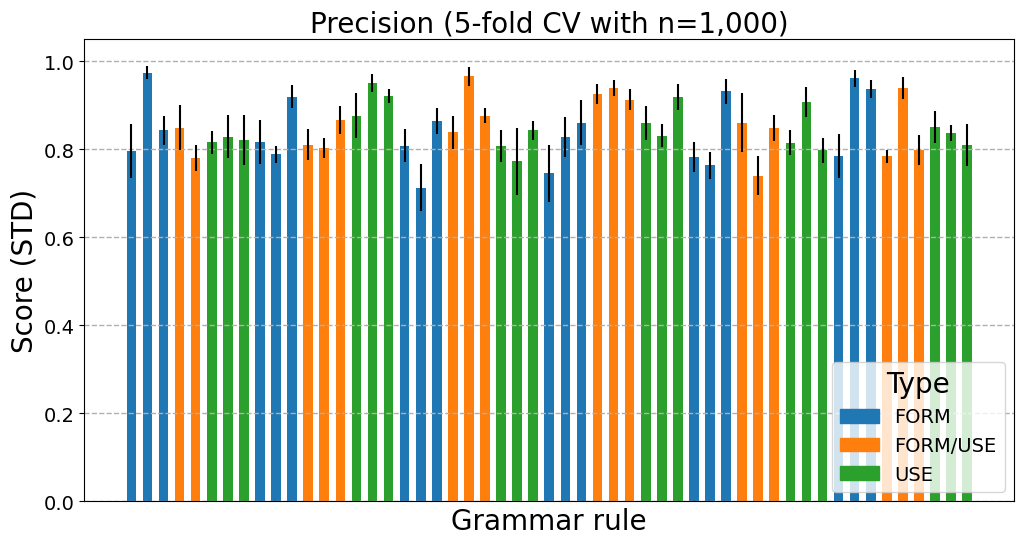

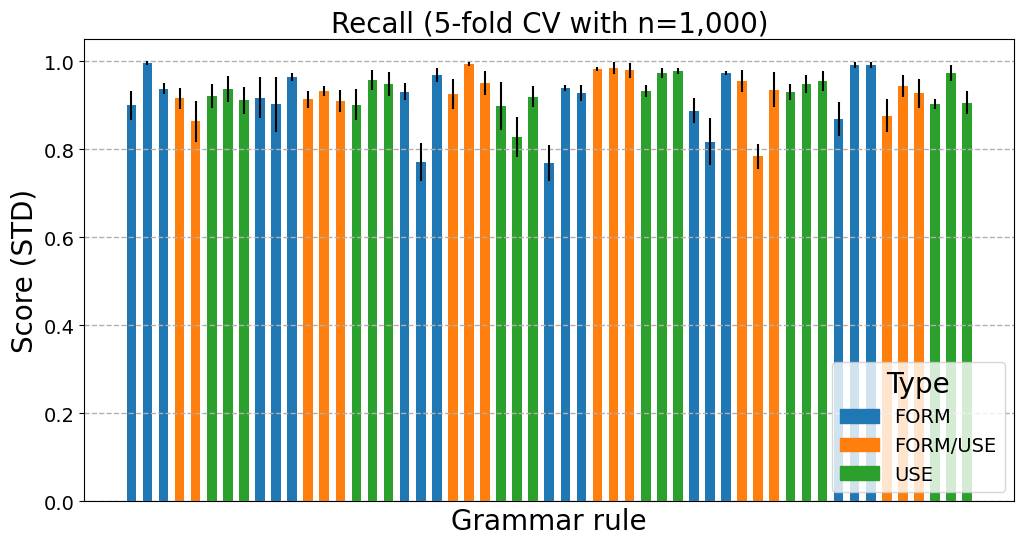

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patches as mpatches

# Update default font sizes
rcParams.update({'font.size': 20, 'axes.labelsize': 20, 'axes.titlesize': 20, 'xtick.labelsize': 14,
                 'ytick.labelsize': 14, 'legend.fontsize': 14})

def calculate_mean_std(values):
    return np.mean(values), np.std(values)

metrics = ['Accuracies', 'Precisions', 'Recalls']
for metric in metrics:
    results_df[[f'{metric} Mean', f'{metric} Std']] = results_df[metric].apply(calculate_mean_std).apply(pd.Series)

width = 0.6
x = np.arange(len(results_df))

categories = results_df['type'].unique()
colors = plt.cm.tab10(range(0, len(categories)))
color_map = dict(zip(categories, colors))

for i, metric in enumerate(metrics):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_ylim(0, 1.05)

    bar = ax.bar(x, results_df[f'{metric} Mean'], width, yerr=results_df[f'{metric} Std'], color=[color_map[t] for t in results_df['type']])

    ax.set_xlabel('Grammar rule')
    ax.set_ylabel('Score (STD)')
    ax.set_title(f'{"Accuracy" if "Acc" in metric else metric[:-1]} (5-fold CV with n=1,000)')
    ax.set_xticks([])

    legend_handles = [mpatches.Patch(color=color_map[cat], label=cat) for cat in categories]
    ax.legend(handles=legend_handles, loc="lower right", title="Type")

    plt.grid(True, which='major', axis='y', linestyle='--', linewidth=1)

    plt.savefig(f'../doc/classification_{metric[:-1].lower()}.pdf', transparent=True, bbox_inches='tight')


Now let's train the models and save them to make them accessible:

In [12]:
batch_size=64
num_epochs=60
hidden_dim=32
random_negatives=True
lr=0.0001

for idx, construction in df.iterrows():
    print(construction['Can-do statement'])
    dataset = get_dataset(construction, random_negatives)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = FeedforwardNN(input_dim, hidden_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        train_steps = 0
        for inputs, targets in loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            train_steps += 1
    
    torch.save(model, f"../models/{construction['#']}.pth")

Can use nouns and noun phrases as complements of the verb 'be'. 
Can use prepositional phrases in the front position for focus.
Can form conditional subordinate clauses with 'if' + past simple, and would in the main clause, to talk about an imagined situation, often in the context of advice or opinion-giving. 
Can use the past perfect continuous in a relative clause to give background information.  ► relative clauses
Can use 'anything' with post-modifiers to form complex noun phrases as subjects with a singular verb, to give focus. 
Can use an increasing range of adjectives before a noun to express intensity.
